# Change Point Identification
- ported from python
- to detect change points in the time series of log(var) of gh500 in the North Atlantic
- use monthly data for simplicity and because spatial aggregation makes daily scale inconsistent

In [1]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")

options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


Linking to GEOS 3.11.1, GDAL 3.6.2, PROJ 9.1.1; sf_use_s2() is TRUE

Lade nötiges Paket: maps


Attache Paket: ‘rnaturalearthdata’


Das folgende Objekt ist maskiert ‘package:rnaturalearth’:

    countries110


Lade nötiges Paket: abind


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Attache Paket: ‘purrr’


Das folgende Objekt ist maskiert ‘package:maps’:

    map



Attache Paket: ‘lubridate’


Das folgende Objekt ist maskiert ‘package:cowplot’:

    stamp


Die folgenden Objekte sind maskiert von ‘package:base’:

    date, intersect, setdiff, union



Attache Paket: ‘data.table’


Die folgenden Objekte sind maskiert von ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


Das folgende Objekt ist maskiert ‘package:purrr’:

    transpose


Die folgenden Objekte sind maskiert von

## Data preprocessing

In [2]:
# List netCDF files matching the pattern "spread_*.nc"
spread_files <- list.files(
    path = DATA_DIR,
    pattern = "^spread_.*\\.nc$",
    full.names = TRUE
)

spread_files <- sort(spread_files)
extract_year <- function(file_name) {
    # Extract the year (digits after last '_' and before '.nc')
    base <- basename(file_name)
    m <- regexpr("_(\\d+)\\.nc$", base, perl = TRUE)
    year_str <- regmatches(base, m)
    year_str <- sub("^_", "", year_str)
    year_str <- sub("\\.nc$", "", year_str)
    as.integer(year_str)
}

years <- sapply(spread_files, extract_year)


In [3]:
# Compute monthly averages for each file
monthly_averages <- lapply(spread_files, calculate_monthly_averages)

# Combine the per-file datasets into one data frame
combined_dataset <- combine_datasets(monthly_averages, years) %>% mutate(
  log_variance = log(avg_z),
  sin_mon = sin(2 * pi * month / 12),
  cos_mon = cos(2 * pi * month / 12)
)

combined_dataset$date <- as.Date(with(
  combined_dataset,
  paste(year, month, "01", sep = "-")
))

combined_dataset$mon_no <-
  (year(combined_dataset$date) - 1940) * 12 + (month(combined_dataset$date) - 1)
str(combined_dataset)


tibble [1,019 × 8] (S3: tbl_df/tbl/data.frame)
 $ month       : num [1:1019] 1 2 3 4 5 6 7 8 9 10 ...
 $ avg_z       : num [1:1019] 114006 84907 73049 98974 77988 ...
 $ year        : int [1:1019] 1940 1940 1940 1940 1940 1940 1940 1940 1940 1940 ...
 $ log_variance: num [1:1019] 11.6 11.3 11.2 11.5 11.3 ...
 $ sin_mon     : num [1:1019] 0.5 0.866 1 0.866 0.5 ...
 $ cos_mon     : num [1:1019] 8.66e-01 5.00e-01 6.12e-17 -5.00e-01 -8.66e-01 ...
 $ date        : Date[1:1019], format: "1940-01-01" "1940-02-01" ...
 $ mon_no      : num [1:1019] 0 1 2 3 4 5 6 7 8 9 ...


# Look at Seasonality of Dataset

**How exactly does the seasonal cycle in the dataset look? And how does it change across change points?**

To find change points and estimate parameters, used [mcp](https://lindeloev.github.io/mcp/index.html); but it didnt work that well and does not permit multiple predictors. So stick with strucchange

1. Find change points assuming annual slope, offset and variance varies 
    1. With the seasonal cycle not varying
    2. With the seasonal cycle varying
3. Visualize
    1. box-whiskers plot for each month for each segment along with a best fit sin-cos
    2. scatter plot with x: amplitude, y: phase (month of maximum) along with uncertainty for annual and segments

In [4]:
ordered_cp_df <- function(bp_est_monthly, data) {
    # Get summary and confidence intervals
    bp_summary <- summary(bp_est_monthly)
    ci_bp_monthly <- confint(bp_est_monthly,
        vcov = sandwich::NeweyWest,
        level = 0.95
    )

    # Extract breakpoints
    cp_indices <- bp_summary$breakpoints[length(bp_est_monthly$breakpoints), ]

    # Compute NA counts for ordering and filter non-NA values
    na_counts <- colSums(is.na(bp_summary$breakpoints))
    valid_indices <- !is.na(cp_indices)
    ordered_indices <- order(na_counts[valid_indices], decreasing = FALSE)
    cp_indices_ordered <- cp_indices[valid_indices][ordered_indices]

    # Convert indices to dates
    matched_indices <- match(cp_indices_ordered, ci_bp_monthly$confint[, 2])
    cp_dates <- data$date[cp_indices_ordered]
    cp_dates_lower <- data$date[ci_bp_monthly$confint[matched_indices, 1]]
    cp_dates_upper <- data$date[ci_bp_monthly$confint[matched_indices, 3]]

    # Create ordered change point data frame
    cp_df <- data.frame(
        cp_date = cp_dates,
        cp_date_lower = cp_dates_lower,
        cp_date_upper = cp_dates_upper,
        cp_no = seq_along(cp_dates) # Identifier for the change points
    )

    return(cp_df)
}



	 Confidence intervals for breakpoints
	 of optimal 6-segment partition: 

Call:
confint.breakpointsfull(object = ar_fit_glob, het.reg = TRUE, 
    het.err = TRUE, vcov. = vcovHC, sandwich = TRUE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1    93         101    102
2   220         221    222
3   468         470    471
4   699         700    702
5   824         825    828

Corresponding to breakdates:
       2.5 % breakpoints    97.5 %
1 0.09126595  0.09911678 0.1000981
2 0.21589794  0.21687929 0.2178606
3 0.45927380  0.46123651 0.4622179
4 0.68596663  0.68694799 0.6889107
5 0.80863592  0.80961727 0.8125613


cp_date,cp_date_lower,cp_date_upper,cp_no
<date>,<date>,<date>,<int>
1958-05-01,1958-04-01,1958-07-01,1
1998-04-01,1998-01-01,1998-12-01,2
1979-02-01,1978-04-01,1979-03-01,3
1948-05-01,1947-02-01,1948-08-01,4
2008-09-01,2008-04-01,2009-09-01,5


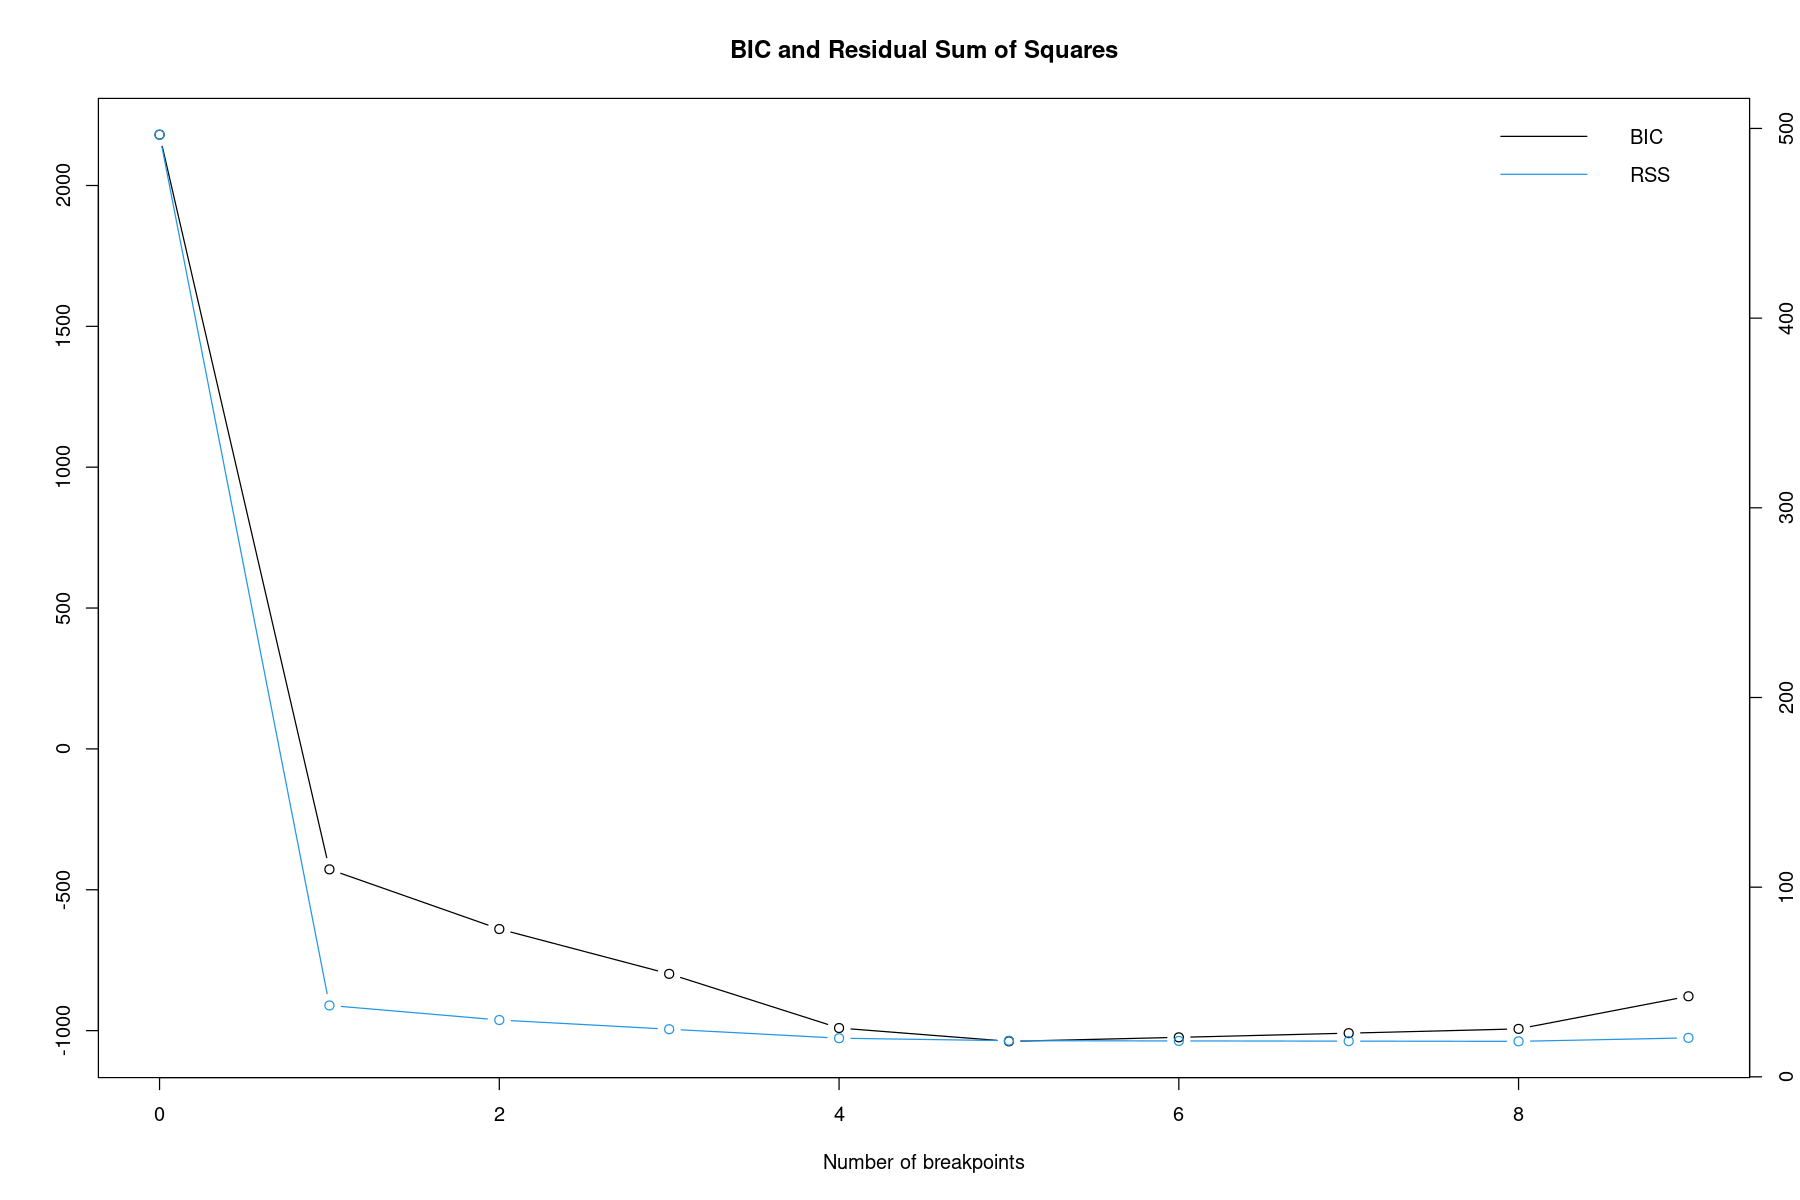

In [31]:
glob_ar_mod <- nlme::gls(
    log_variance ~ 1,
    data        = combined_dataset,
    correlation = corAR1(form = ~mon_no)
)

filtered_df <- combined_dataset %>%
    mutate(ar_filtered = residuals(glob_ar_mod))


ar_fit_glob <- breakpoints(
    ar_filtered ~ year,
    data     = filtered_df,
    h        = .1,
    breaks   = NULL
)
par(bg = "white")
plot(ar_fit_glob)
print(confint(ar_fit_glob,
    het.err = TRUE,
    het.reg = TRUE,
    sandwich = TRUE,
    vcov. = vcovHC
))

cp_df <- ordered_cp_df(ar_fit_glob, combined_dataset)
cp_df


In [ ]:
combined_dataset$segment_no_seas <- breakfactor(ar_fit_glob)


# Fit the segmented linear model with segment-specific predictors
lmod_monthly_no_seas <- nlme::gls(
    log_variance ~ segment_no_seas +
        segment_no_seas:year - 1,
    data = combined_dataset,
    correlation = corAR1(form = ~ mon_no | segment_no_seas),
    weights = varIdent(form = ~ 1 | segment_no_seas)
)

# Summarize the segmented model results
summary(lmod_monthly_no_seas)


Generalized least squares fit by REML
  Model: log_variance ~ segment_no_seas + segment_no_seas:year - 1 
  Data: combined_dataset 
        AIC       BIC   logLik
  -1806.834 -1713.454 922.4172

Correlation Structure: AR(1)
 Formula: ~mon_no | segment_no_seas 
 Parameter estimate(s):
      Phi 
0.6810861 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment_no_seas 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6 
1.0000000 0.8258232 0.4596352 0.3391152 0.2654712 0.2611998 

Coefficients:
                                Value Std.Error    t-value p-value
segment_no_seassegment1      519.9913  51.30793  10.134715   0e+00
segment_no_seassegment2      360.5351  33.12974  10.882522   0e+00
segment_no_seassegment3       57.4175   6.56053   8.751960   0e+00
segment_no_seassegment4       41.1513   5.49601   7.487492   0e+00
segment_no_seassegment5      120.5363  10.38997  11.601224   0e+00
segment_no_seassegment6    

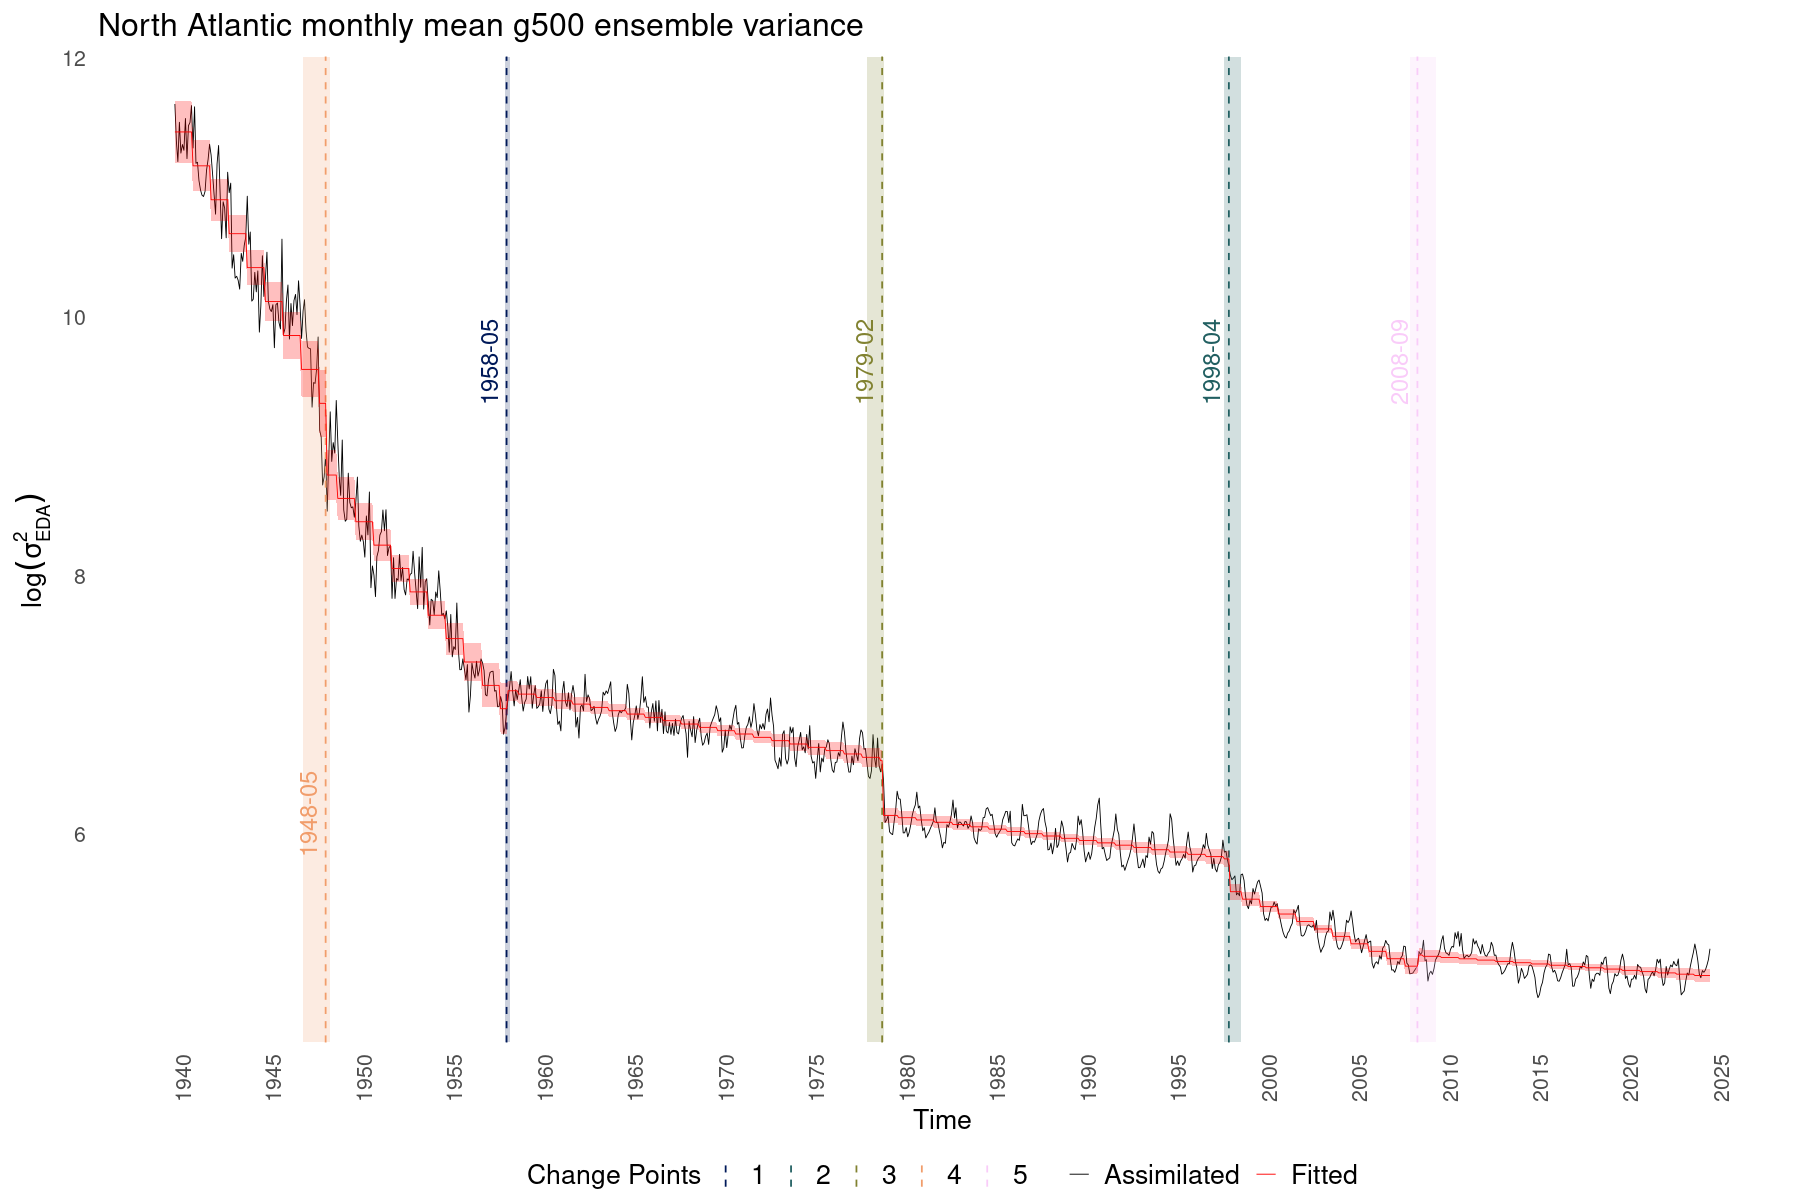

In [34]:
p <- plot_change_points(
    data = combined_dataset,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE
)

fitted_layers <- add_fitted_line_ci(lmod_monthly_no_seas, combined_dataset)
for (layer in fitted_layers) {
    p <- p + layer
}
p + THEME_PUB_LARGE


In [35]:
seasonal_model <- nlme::gls(
    log_variance ~ year:segment_no_seas + segment_no_seas +
        sin_mon + cos_mon - 1,
    data = combined_dataset,
    correlation = corAR1(form = ~ mon_no | segment_no_seas),
    weights = varIdent(form = ~ 1 | segment_no_seas)
)

summary(seasonal_model)


Generalized least squares fit by REML
  Model: log_variance ~ year:segment_no_seas + segment_no_seas + sin_mon +      cos_mon - 1 
  Data: combined_dataset 
        AIC       BIC   logLik
  -2003.054 -1899.887 1022.527

Correlation Structure: AR(1)
 Formula: ~mon_no | segment_no_seas 
 Parameter estimate(s):
     Phi 
0.594905 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment_no_seas 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6 
1.0000000 0.8582858 0.4554133 0.2873428 0.2377706 0.2357218 

Coefficients:
                                Value Std.Error    t-value p-value
segment_no_seassegment1      515.3024  40.07714  12.857763  0.0000
segment_no_seassegment2      368.2416  26.75656  13.762666  0.0000
segment_no_seassegment3       58.6330   4.96942  11.798781  0.0000
segment_no_seassegment4       42.1990   3.56361  11.841639  0.0000
segment_no_seassegment5      122.5092   7.21524  16.979220  0.0000
segm

In [40]:
trend_only_df <- combined_dataset %>%
    mutate(
        sin_mon = 0,
        cos_mon = 0
    )

# Now predict() this
combined_dataset <- combined_dataset %>%
    mutate(
        fitted_trend_only = predict(seasonal_model, newdata = trend_only_df)
    )

# The “deseasonalized” response is
#    y_i^(ds) = log_variance_i - fitted_trend_i
combined_dataset <- combined_dataset %>%
    mutate(
        y_seas = log_variance - fitted_trend_only
    )

# ── 4) Extract the seasonal‐term coefficients + 2×2 covariance ───────────────────
coefs_all <- coef(seasonal_model)
beta_sin <- coefs_all["sin_mon"]
beta_cos <- coefs_all["cos_mon"]

V_all <- vcov(seasonal_model)
V_seas <- V_all[c("sin_mon", "cos_mon"), c("sin_mon", "cos_mon")]

df_resid <- nrow(combined_dataset) - length(coef(seasonal_model))

# ── 5) Build a 12‐row data.frame giving month = 1…12, sin_mon, cos_mon ─────────
new_season <- tibble(
    month = 1:12
) %>%
    mutate(
        sin_mon = sin(2 * pi * (month / 12)),
        cos_mon = cos(2 * pi * (month / 12))
    ) %>%
    rowwise() %>%
    mutate(
        # point‐estimate of the seasonal fit
        fit = beta_sin * sin_mon + beta_cos * cos_mon,

        # its standard error:  sqrt([s c] %*% V_seas %*% [s; c])
        se = sqrt(
            c(sin_mon, cos_mon) %*% V_seas %*% matrix(c(sin_mon, cos_mon), ncol = 1)
        )
    ) %>%
    ungroup() %>%
    mutate(
        lwr = fit - qt(0.975, df = df_resid) * se,
        upr = fit + qt(0.975, df = df_resid) * se
    )


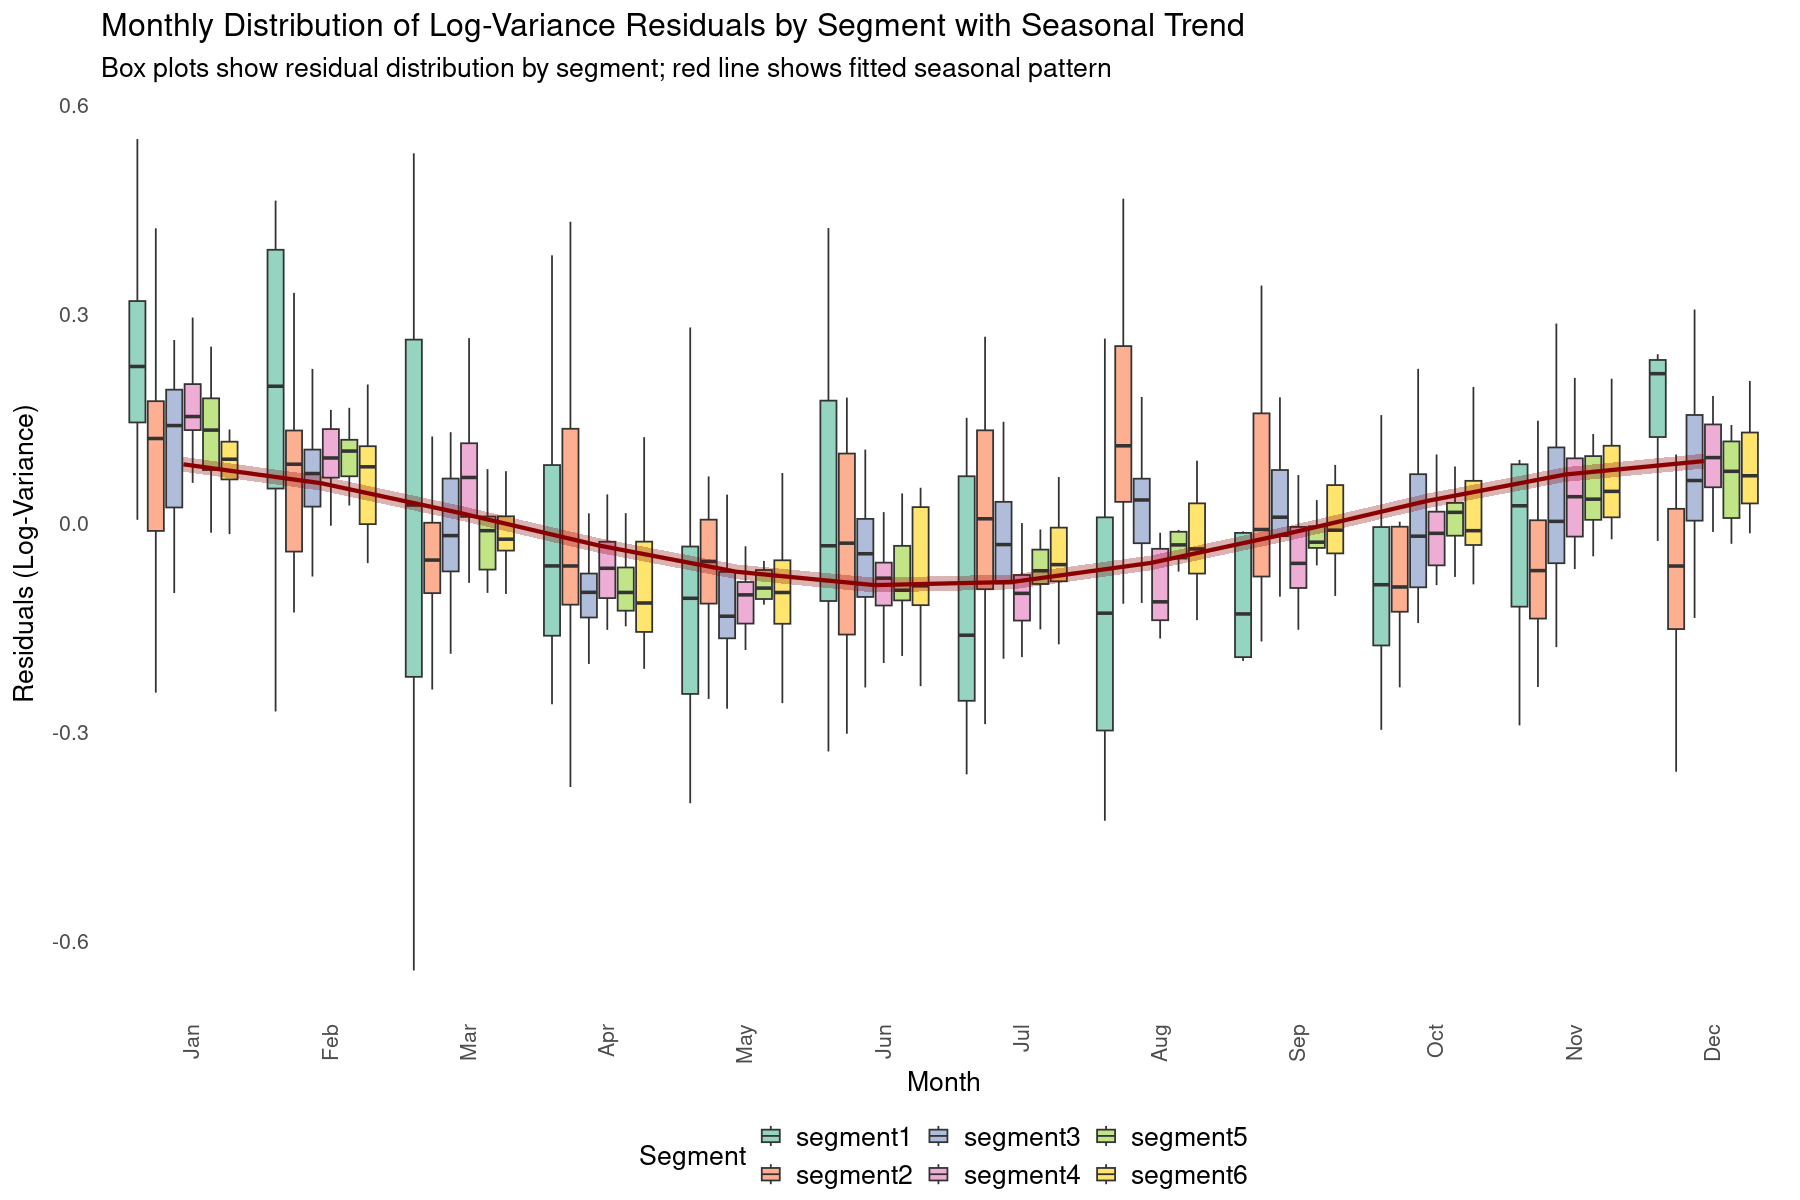

In [41]:
p <- ggplot(combined_dataset, aes(x = factor(month), fill = segment_no_seas)) +
    # Box plots for residuals by month and segment
    geom_boxplot(aes(y = y_deseas),
        alpha = 0.7,
        outlier.shape = NA, # Remove outliers
        width = 0.7, # Make boxes narrower
        position = position_dodge(width = 0.8) # Space out the boxes
    ) +
    # Use a color palette that works well with 6 segments
    scale_fill_brewer(type = "qual", palette = "Set2", name = "Segment") +
    geom_ribbon(
        data = new_season,
        aes(x = month, ymin = lwr, ymax = upr, group = 1, fill = NULL),
        alpha = 0.3,
        fill = "darkred",
        inherit.aes = FALSE
    ) +
    # Add seasonal trend line
    geom_line(
        data = new_season,
        aes(x = month, y = fit, group = 1, fill = NULL),
        color = "darkred",
        size = 1.2,
        linetype = "solid",
        inherit.aes = FALSE
    ) +
    # Customize the plot
    scale_x_discrete(labels = month.abb) +
    labs(
        title = "Monthly Distribution of Log-Variance Residuals by Segment with Seasonal Trend",
        subtitle = "Box plots show residual distribution by segment; red line shows fitted seasonal pattern",
        x = "Month",
        y = "Residuals (Log-Variance)"
    ) +
    THEME_PUB_LARGE

# Display the plot
print(p)


**The above shows that it is crucial to allow the seasonal cycle to vary between segments! See also the last section in this notebook**

In [15]:
p <- ggplot(combined_dataset, aes(x = factor(month))) +
    # Box plots for residuals by month
    geom_boxplot(aes(y = residuals_no_seas),
        alpha = 0.7,
        fill = "lightblue",
        outlier.color = "darkblue",
        outlier.alpha = 0.6
    ) +
    geom_ribbon(
        data = seasonal_df,
        aes(x = month, ymin = lwr, ymax = upr, group = 1),
        alpha = 0.3,
        fill = "darkred"
    ) +

    # Add seasonal trend line
    geom_line(
        data = seasonal_df,
        aes(x = month, y = fit, group = 1),
        color = "darkred",
        size = 1.2,
        linetype = "solid"
    ) +
    # Customize the plot
    scale_x_discrete(labels = month.abb) +
    labs(
        title = "Monthly Distribution of Log-Variance Residuals with Seasonal Trend",
        subtitle = "Box plots show residual distribution; red line shows fitted seasonal pattern",
        x = "Month",
        y = "Residuals (Log-Variance)"
    ) +
    THEME_PUB_LARGE
# Display the plot
print(p)


ERROR: Error in fortify(data): Objekt 'seasonal_df' nicht gefunden


## Binary Segmentation
- legacy code because breakpoints in regressions is more suitable

In [ ]:
flattened_data <- combined_dataset$avg_z
log_data <- log(flattened_data)

#---------------- Change Point Detection and Plotting ------------------------
max_cp_vec <- 1:4

# Prepare an empty data frame to accumulate change point info:
# cp_index: index in the time series
# cp_date: the corresponding date
# max_cp: the hierarchical level (i.e. the iteration when first found)
cp_df <- data.frame(
    cp_index = integer(),
    cp_date = as.Date(character()),
    max_cp = integer(),
    stringsAsFactors = FALSE
)

# Loop over each max_cp value and detect change points hierarchically.
for (i in seq_along(max_cp_vec)) {
    max_cp <- max_cp_vec[i]
    cpt_obj <- cpt.mean(log_data,
        method = "BinSeg", Q = max_cp,
        class = TRUE
    )
    # cpts() returns the indices of the change points (including the final index)
    cps <- cpts(cpt_obj)
    cps <- cps[cps < length(flattened_data)]

    # Save only newly found change points
    new_cps <- cps[!cps %in% cp_df$cp_index]

    if (length(new_cps) > 0) {
        for (cp in new_cps) {
            cp_df <- rbind(
                cp_df,
                data.frame(
                    cp_index = cp,
                    cp_date = combined_dataset$date[cp],
                    max_cp = max_cp,
                    stringsAsFactors = FALSE
                )
            )
        }
        cat(
            "Max change points:", max_cp,
            "-> New cp detected at indices:", paste(new_cps, collapse = ", "),
            "which correspond to dates:",
            paste(as.character(combined_dataset$date[new_cps]),
                collapse = ", "
            ), "\n"
        )
    } else {
        cat(
            "Max change points:", max_cp,
            "-> No new change points detected.\n"
        )
    }
}

#--- Build the base plot using actual date values on the x-axis ---------------
p <- ggplot(data = combined_dataset, aes(x = date, y = avg_z)) +
    geom_line() +
    scale_y_log10() +
    labs(
        x = "Time", y = "Log(Var)",
        title = "Original Data with Detected Change Points",
        color = "Hierarchy"
    ) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    THEME_PUB +
    scale_x_date(date_breaks = "5 year", date_labels = "%Y") +
    scale_color_scico_d(palette = "batlow") # discrete colour scale

#--- Add vertical lines and annotations for change points --------------------
if (nrow(cp_df) > 0) {
    y_pos <- max(combined_dataset$avg_z, na.rm = TRUE) * .7
    p <- p +
        geom_vline(
            data = cp_df, aes(
                xintercept = cp_date,
                color = factor(max_cp)
            ),
            linetype = "dashed", linewidth = 1
        ) +
        geom_text(
            data = cp_df, aes(
                x = cp_date, y = y_pos,
                label = format(cp_date, "%Y-%m"),
                color = factor(max_cp)
            ),
            angle = 90, vjust = -0.5, hjust = 0, size = 5, show.legend = FALSE
        ) +
        guides(color = guide_legend(
            override.aes = list(
                shape = NA,
                linetype = "dashed"
            )
        )) +
        theme(
            legend.title = element_text(size = 18),
            legend.text = element_text(size = 18),
            legend.key.size = unit(2, "lines")
        )
}

#--- Display the plot ---------------------------------------------------------
print(p)

#--- Print out the exact time values (and indices) identified ----------------
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}


In [ ]:
max_cp_vec <- 1:4

# Detect change points
cp_df <- detect_change_points(
    log_data,
    combined_dataset$date,
    max_cp_vec
)

# Create the plot (THEME_PUB can be passed if defined)
p <- plot_change_points(combined_dataset, cp_df, theme_pub = THEME_PUB)

# Display the plot
print(p)

# Print the detected change points
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}


## Multiple structural change models (Bai & Perron, 2003)
**Challenge:** Choose either max number of breakpoints or minimum segment size?

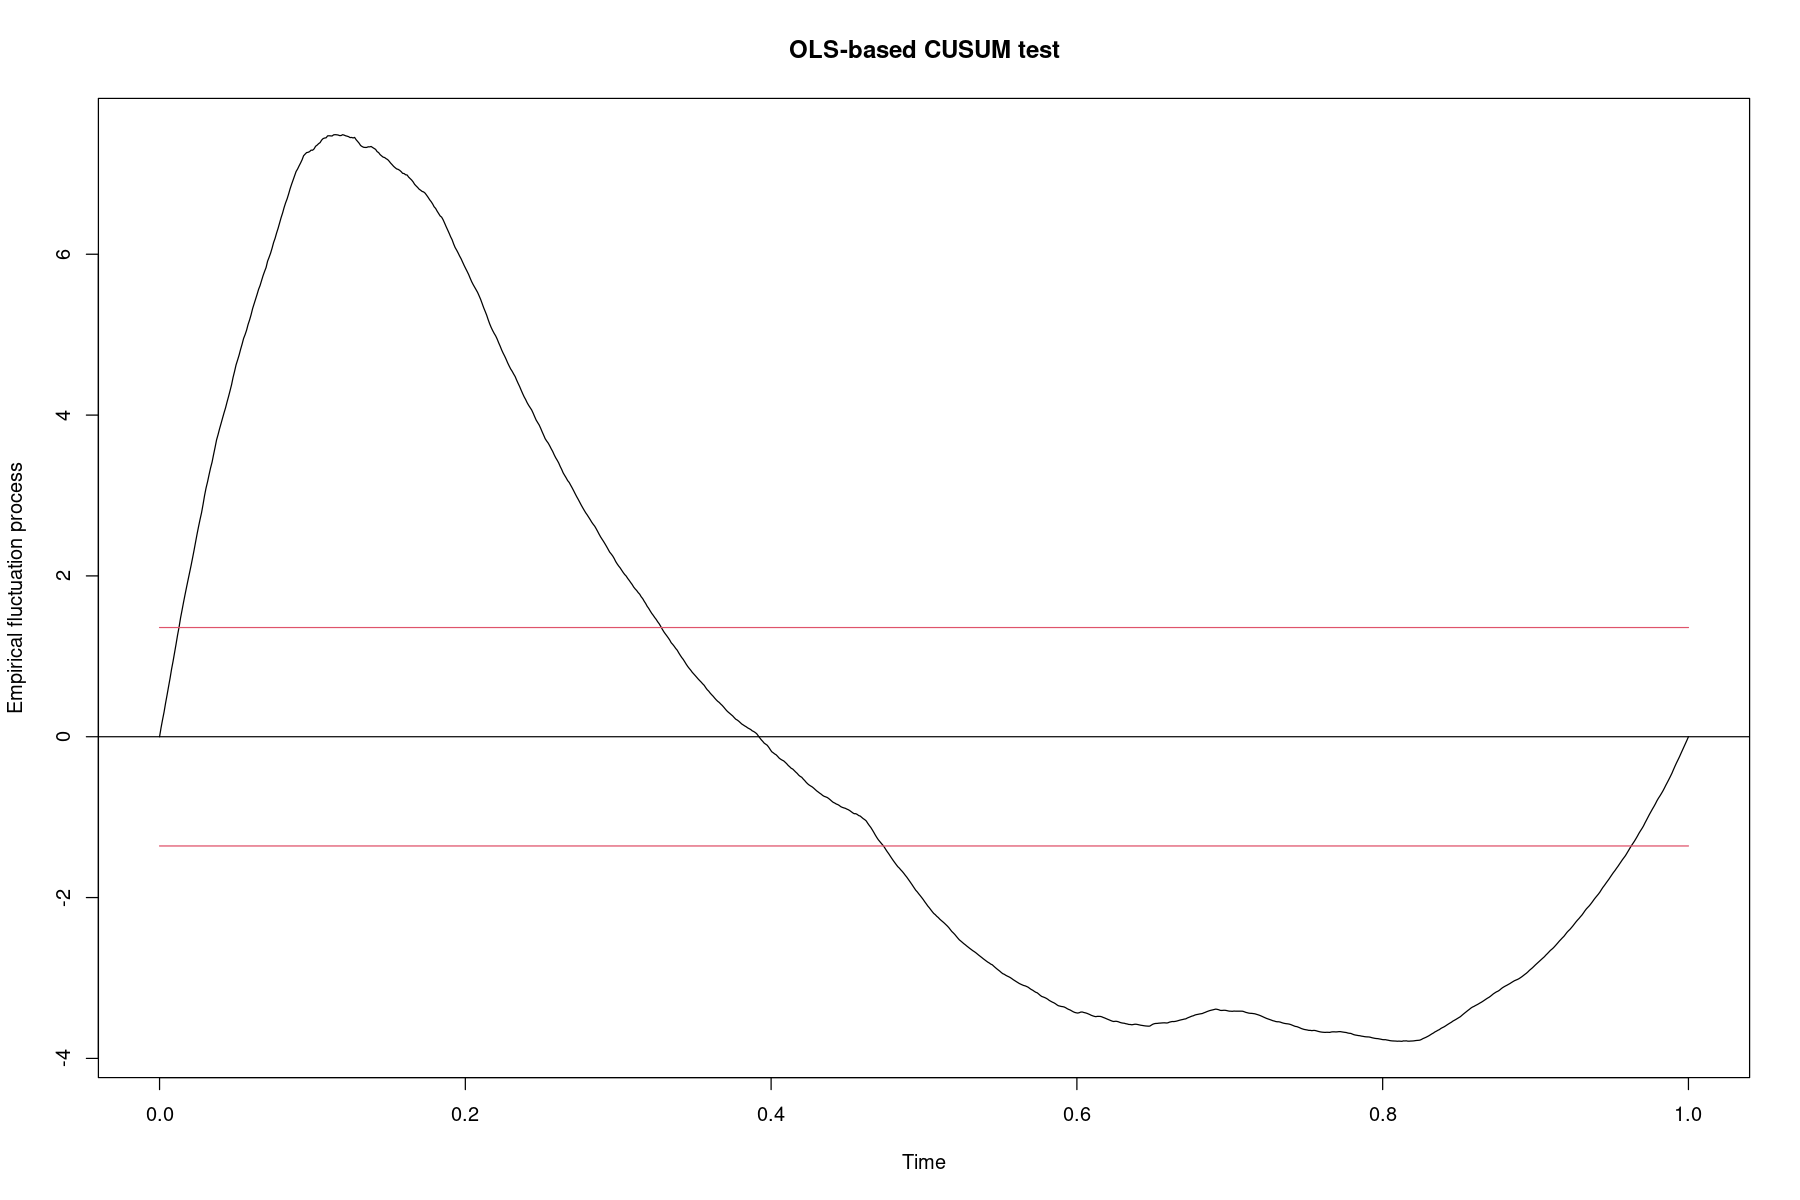

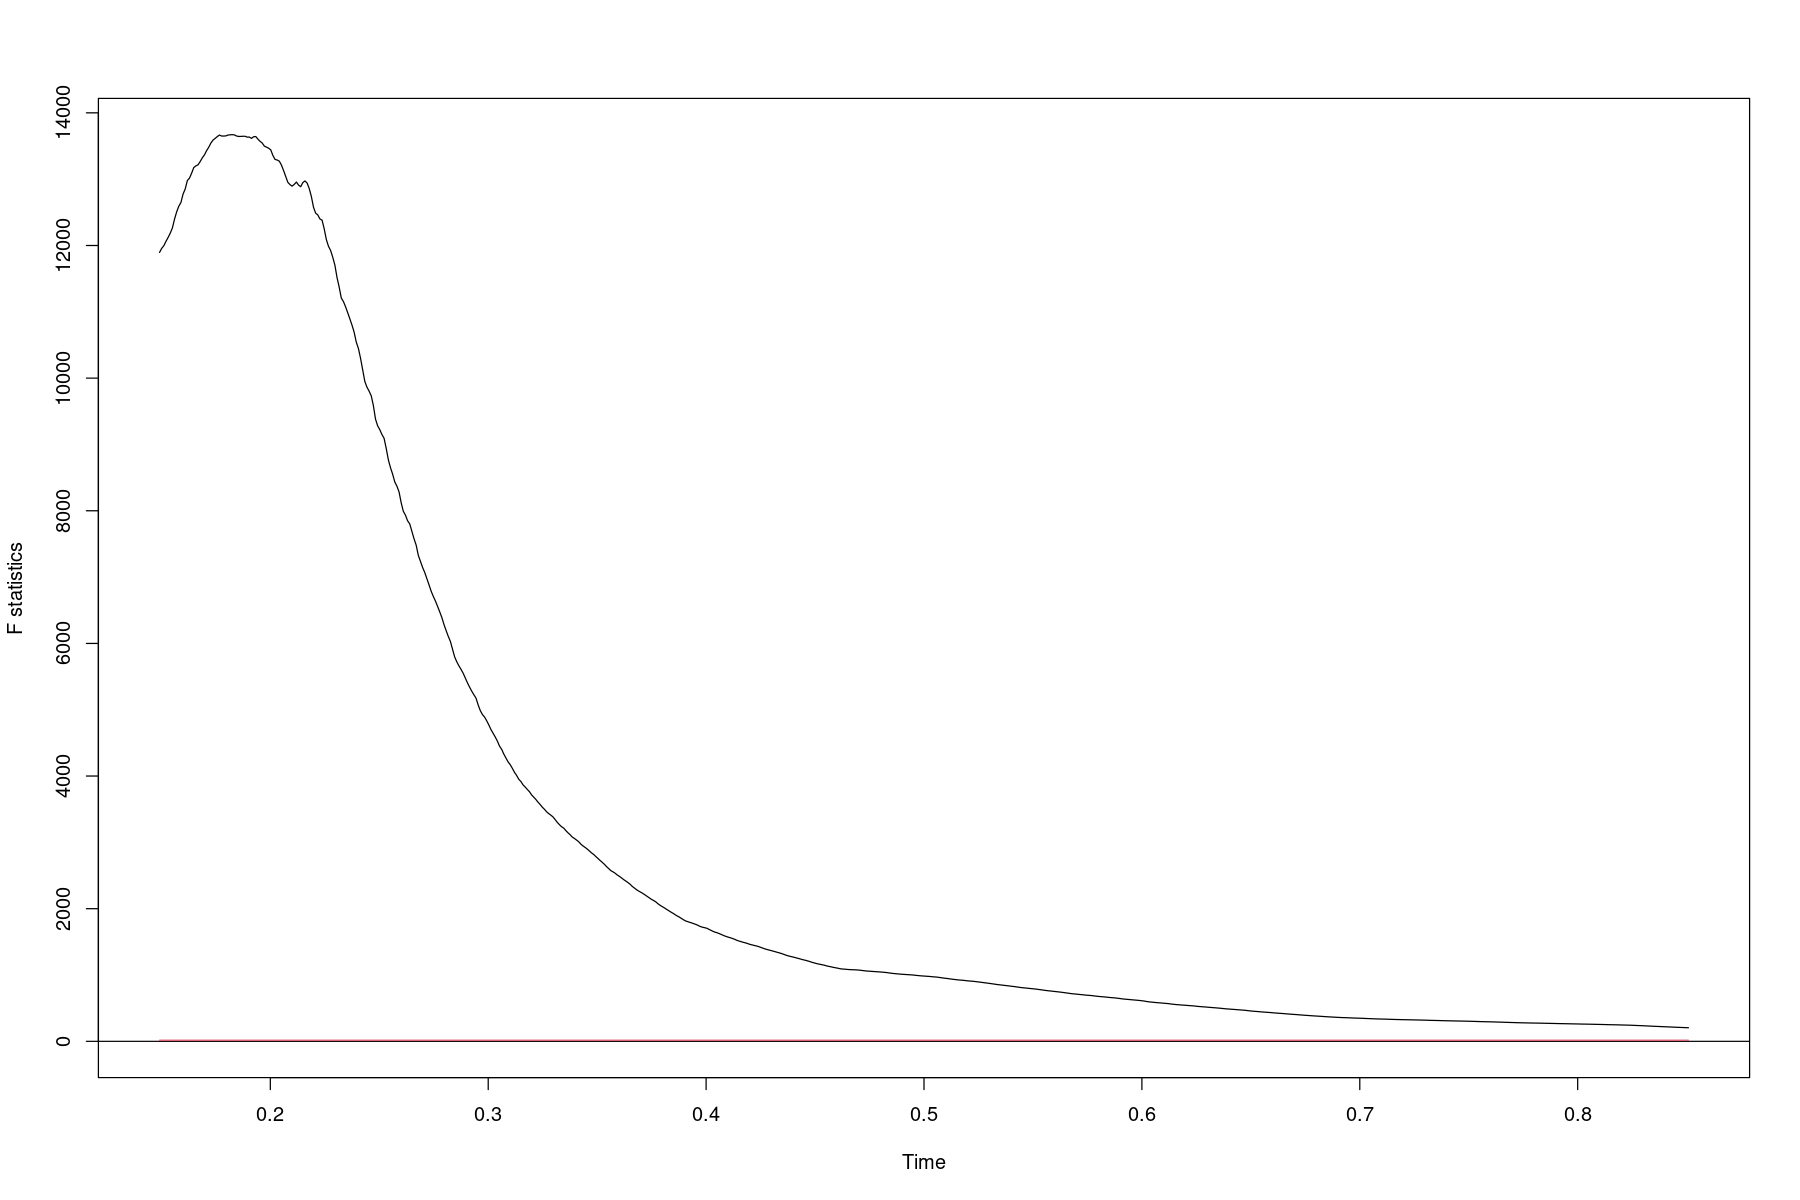

In [43]:
par(bg = "white")

ocus <- efp(
    formula = ar_filtered ~ year + sin_mon + cos_mon,
    data = filtered_df,
    type = "OLS-CUSUM"
)

plot(ocus)

fs <- Fstats(ar_filtered ~ year + sin_mon + cos_mon, data = filtered_df)
plot(fs)


pdf 
  2


	 Optimal 6-segment partition: 

Call:
breakpoints.formula(formula = ar_filtered ~ year + sin_mon + 
    cos_mon, h = 0.1, breaks = NULL, data = filtered_df)

Breakpoints at observation number:
109 222 471 704 828 

Corresponding to breakdates:
0.1069676 0.2178606 0.4622179 0.6908734 0.8125613 

	 Confidence intervals for breakpoints
	 of optimal 6-segment partition: 

Call:
confint.breakpointsfull(object = bp_est_monthly, het.reg = TRUE, 
    het.err = TRUE, vcov. = vcovHC, sandwich = TRUE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1   104         109    110
2   221         222    223
3   470         471    472
4   703         704    705
5   827         828    830

Corresponding to breakdates:
      2.5 % breakpoints    97.5 %
1 0.1020608   0.1069676 0.1079490
2 0.2168793   0.2178606 0.2188420
3 0.4612365   0.4622179 0.4631992
4 0.6898921   0.6908734 0.6918548
5 0.8115800   0.8125613 0.8145240


cp_date,cp_date_lower,cp_date_upper,cp_no
<date>,<date>,<date>,<int>
1958-06-01,1958-05-01,1958-08-01,1
1998-08-01,1998-07-01,1998-11-01,2
1949-01-01,1948-06-01,1949-03-01,3
1979-03-01,1979-01-01,1979-04-01,4
2008-12-01,2008-10-01,2009-08-01,5


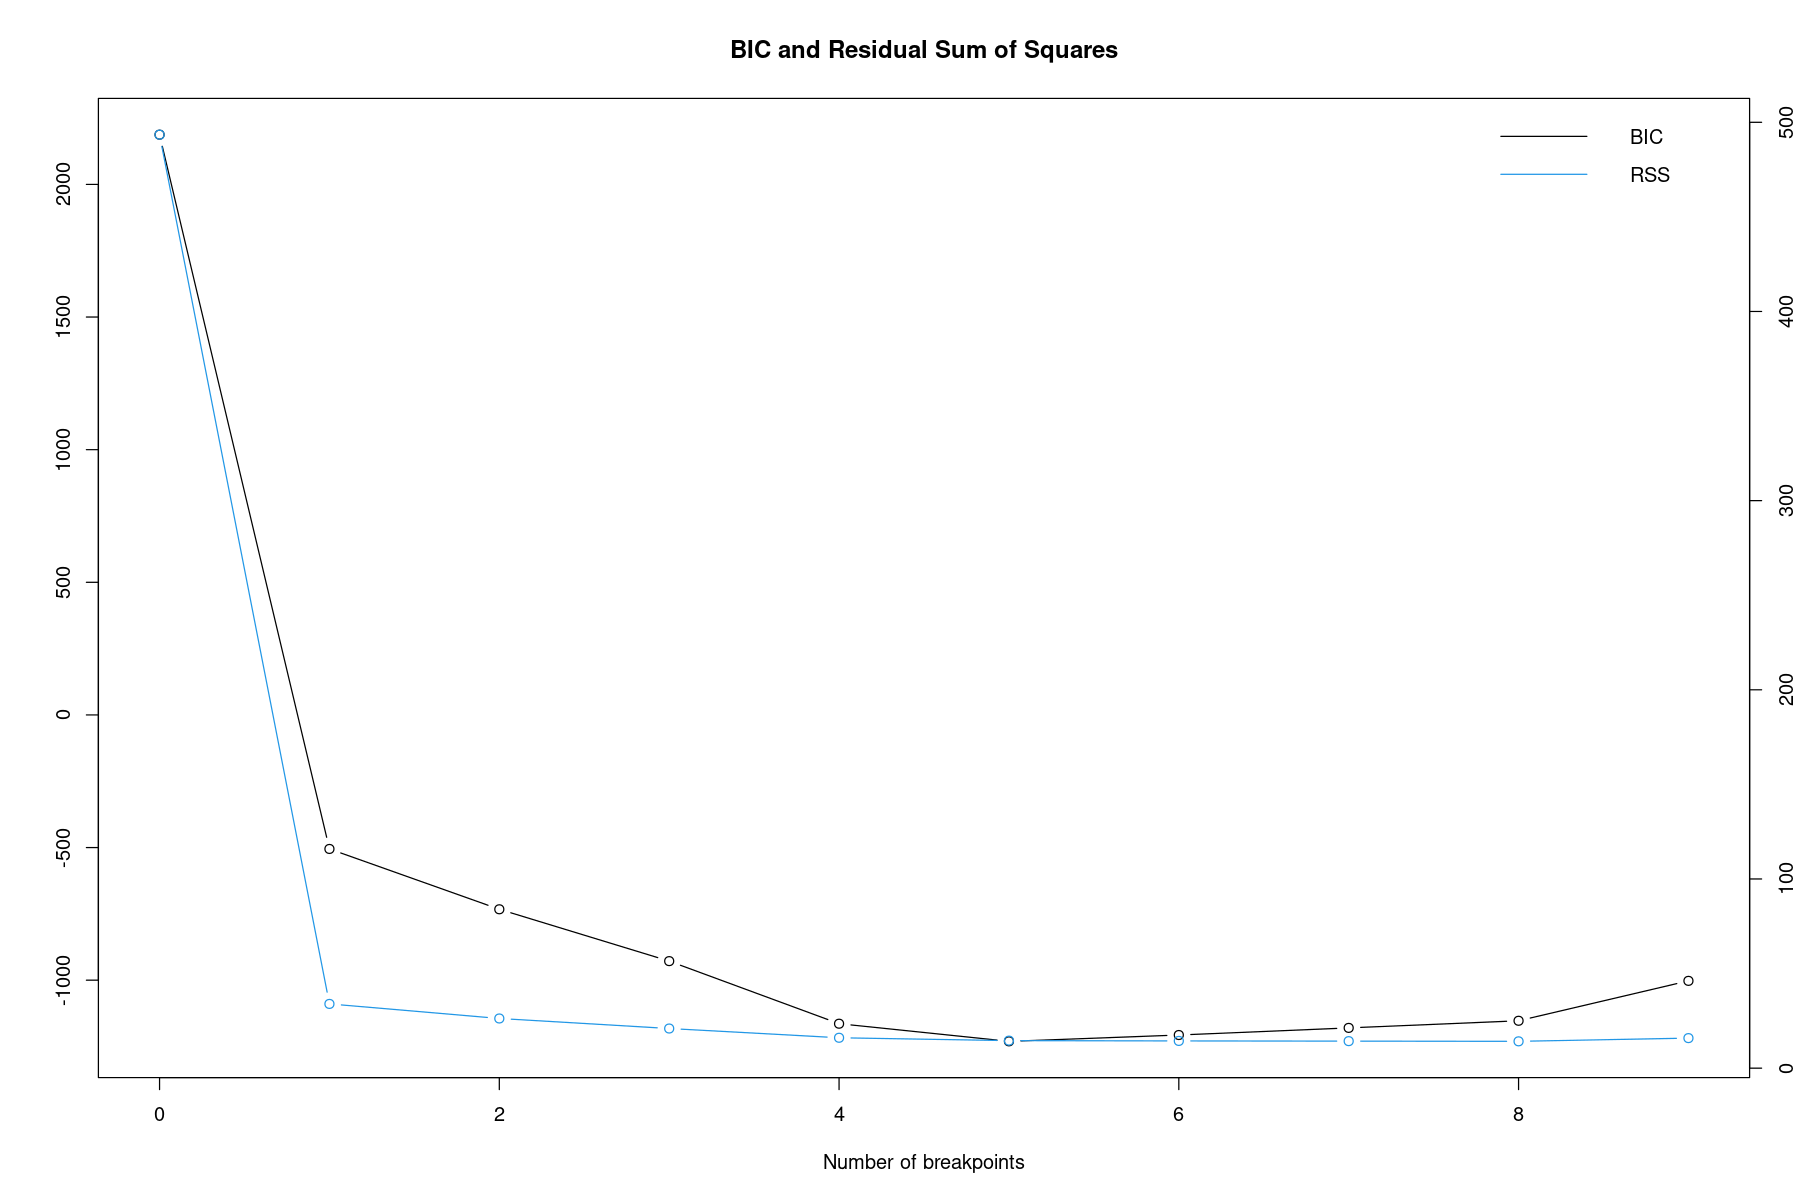

In [44]:
# Estimate breakpoints with seasonal predictors differing in each segment
# Control for AR(1)
bp_est_monthly <- breakpoints(ar_filtered ~ year + sin_mon + cos_mon,
    data = filtered_df,
    h = .1,
    breaks = NULL
)
par(bg = "white")
plot(bp_est_monthly)
pdf(paste0(OUT_DIR, "BIC_breakpoints.pdf"), width = 4, height = 3)
plot(bp_est_monthly)
dev.off()
print(bp_est_monthly)
print(confint(bp_est_monthly,
    het.err = TRUE,
    het.reg = TRUE,
    sandwich = TRUE,
    vcov. = vcovHC
))
cp_df <- ordered_cp_df(bp_est_monthly, combined_dataset)
cp_df


In [45]:
combined_dataset$segment <- breakfactor(bp_est_monthly)


# Fit the segmented linear model with segment-specific predictors
lmod_seas_monthly <- nlme::gls(
    log_variance ~ segment +
        segment:year + segment:sin_mon + segment:cos_mon - 1,
    data = combined_dataset,
    correlation = corAR1(form = ~ mon_no | segment),
    weights = varIdent(form = ~ 1 | segment)
)

# Summarize the segmented model results
summary(lmod_seas_monthly)


Generalized least squares fit by REML
  Model: log_variance ~ segment + segment:year + segment:sin_mon + segment:cos_mon -      1 
  Data: combined_dataset 
        AIC       BIC   logLik
  -2004.752 -1852.767 1033.376

Correlation Structure: AR(1)
 Formula: ~mon_no | segment 
 Parameter estimate(s):
      Phi 
0.5653052 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6 
1.0000000 0.7808411 0.4423234 0.2590681 0.2171303 0.2320569 

Coefficients:
                           Value Std.Error    t-value p-value
segmentsegment1         541.2494  34.45567  15.708573  0.0000
segmentsegment2         354.1914  25.63986  13.814093  0.0000
segmentsegment3          58.6851   4.59831  12.762320  0.0000
segmentsegment4          41.9736   2.99790  14.000983  0.0000
segmentsegment5         112.5377   6.40576  17.568196  0.0000
segmentsegment6          25.5409   3.66370   6.9

Warning message:
“Using size for a discrete variable is not advised.”


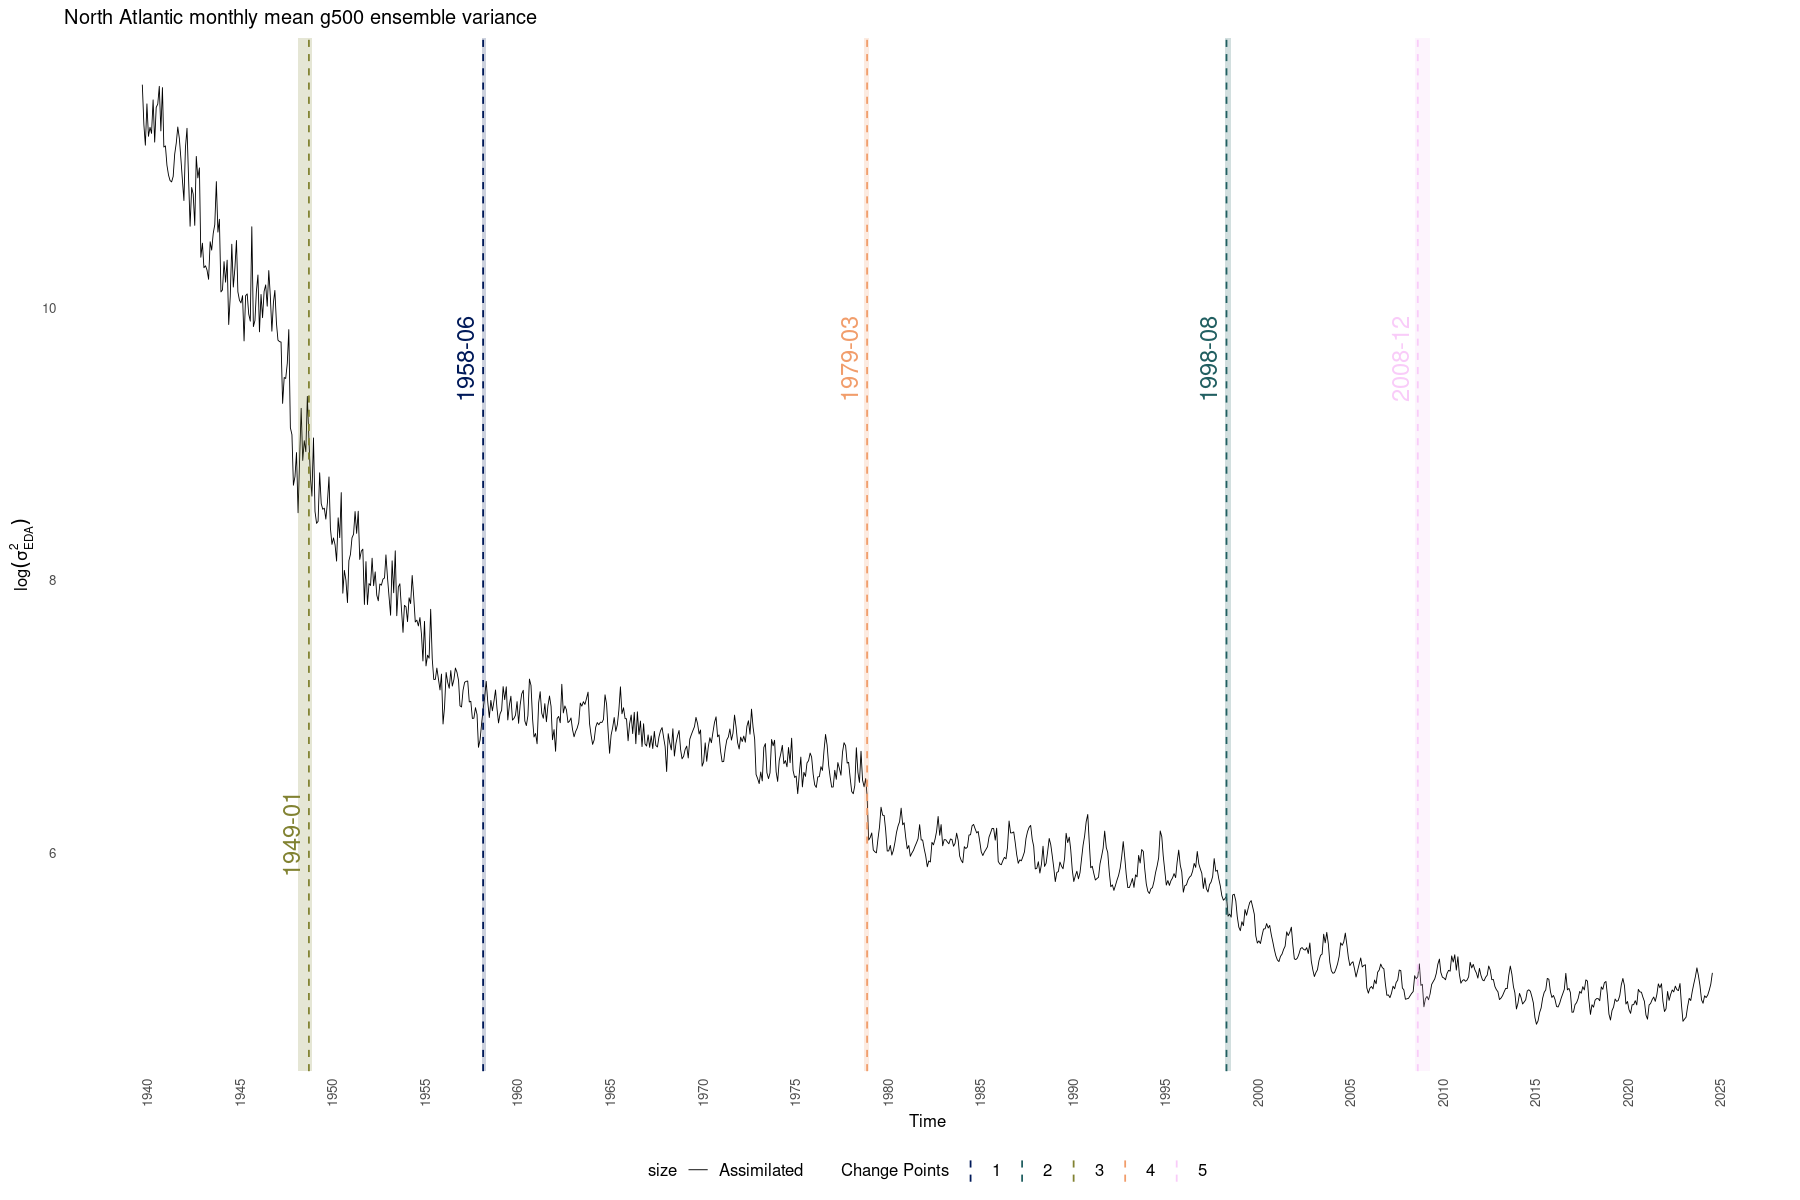

pdf 
  2

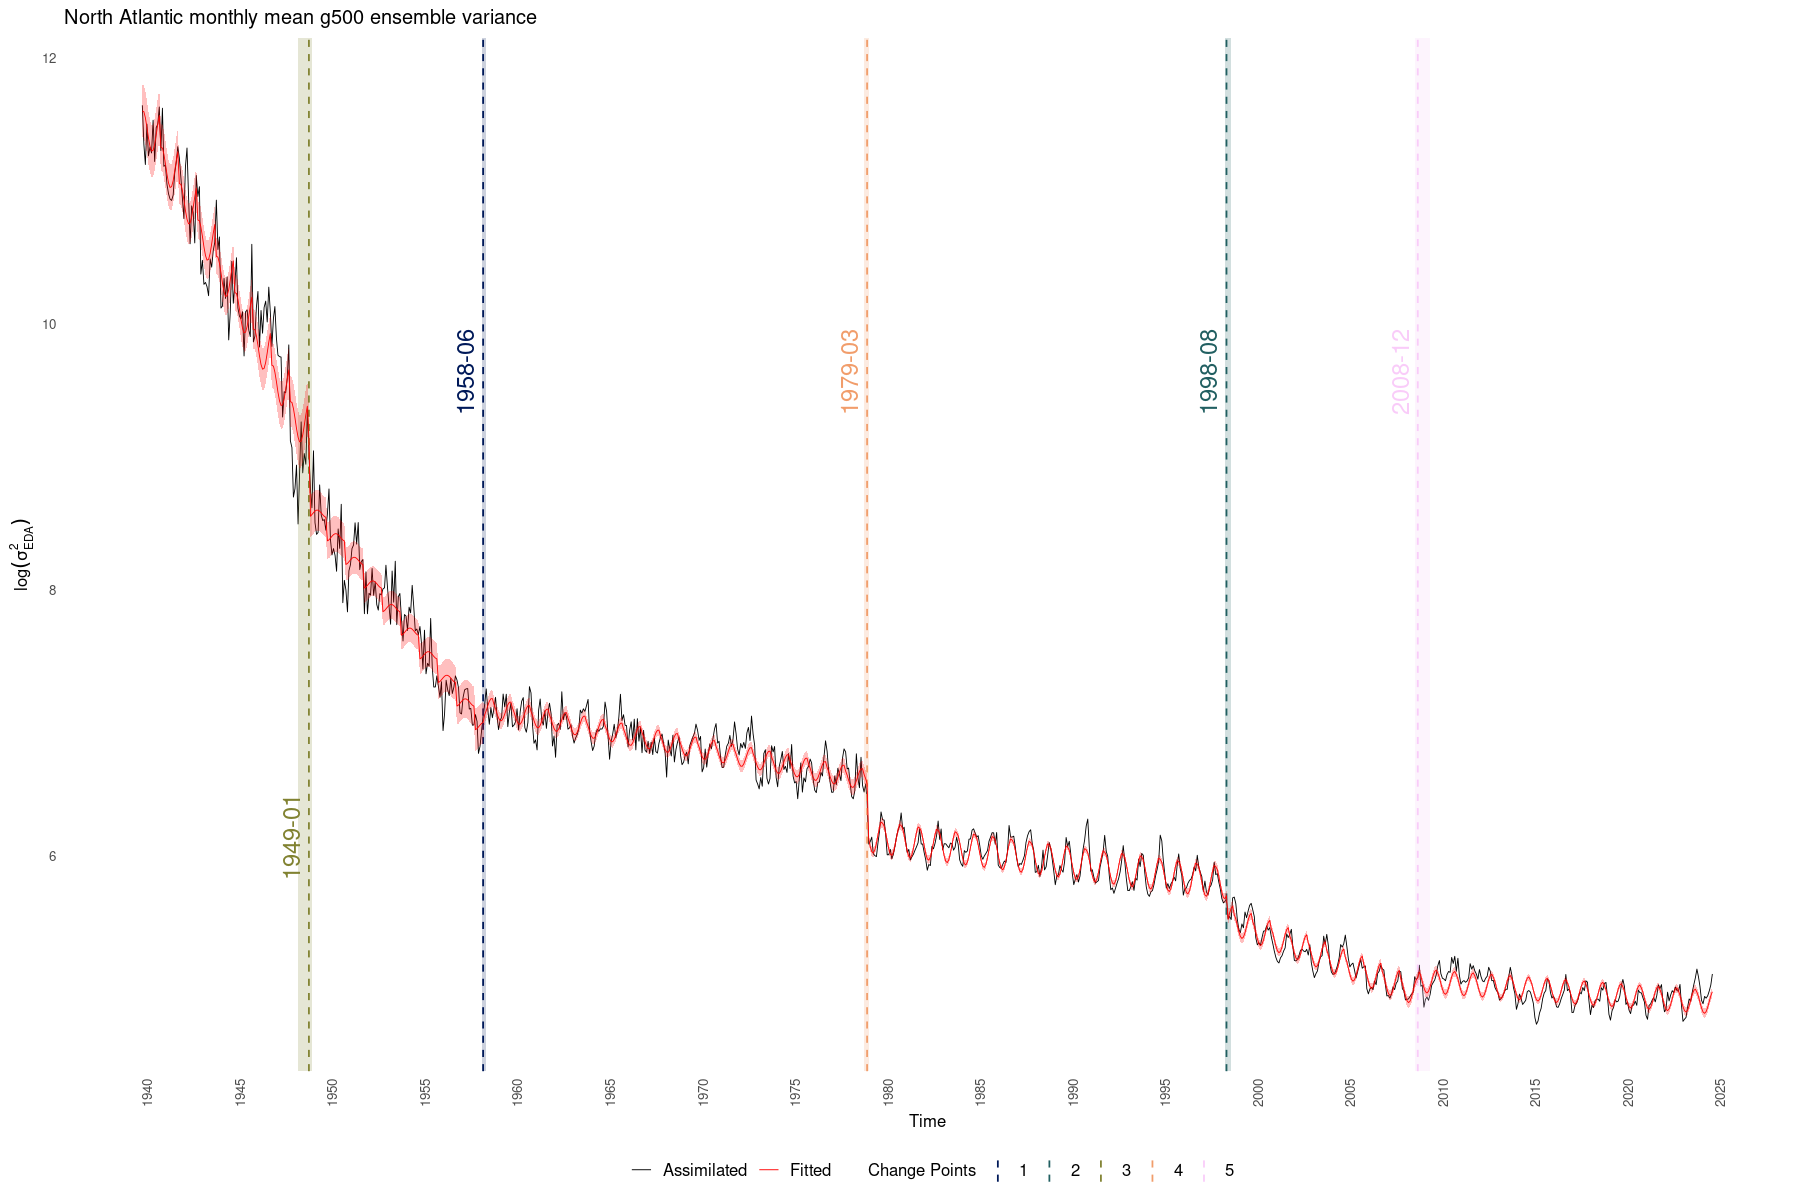

pdf 
  2

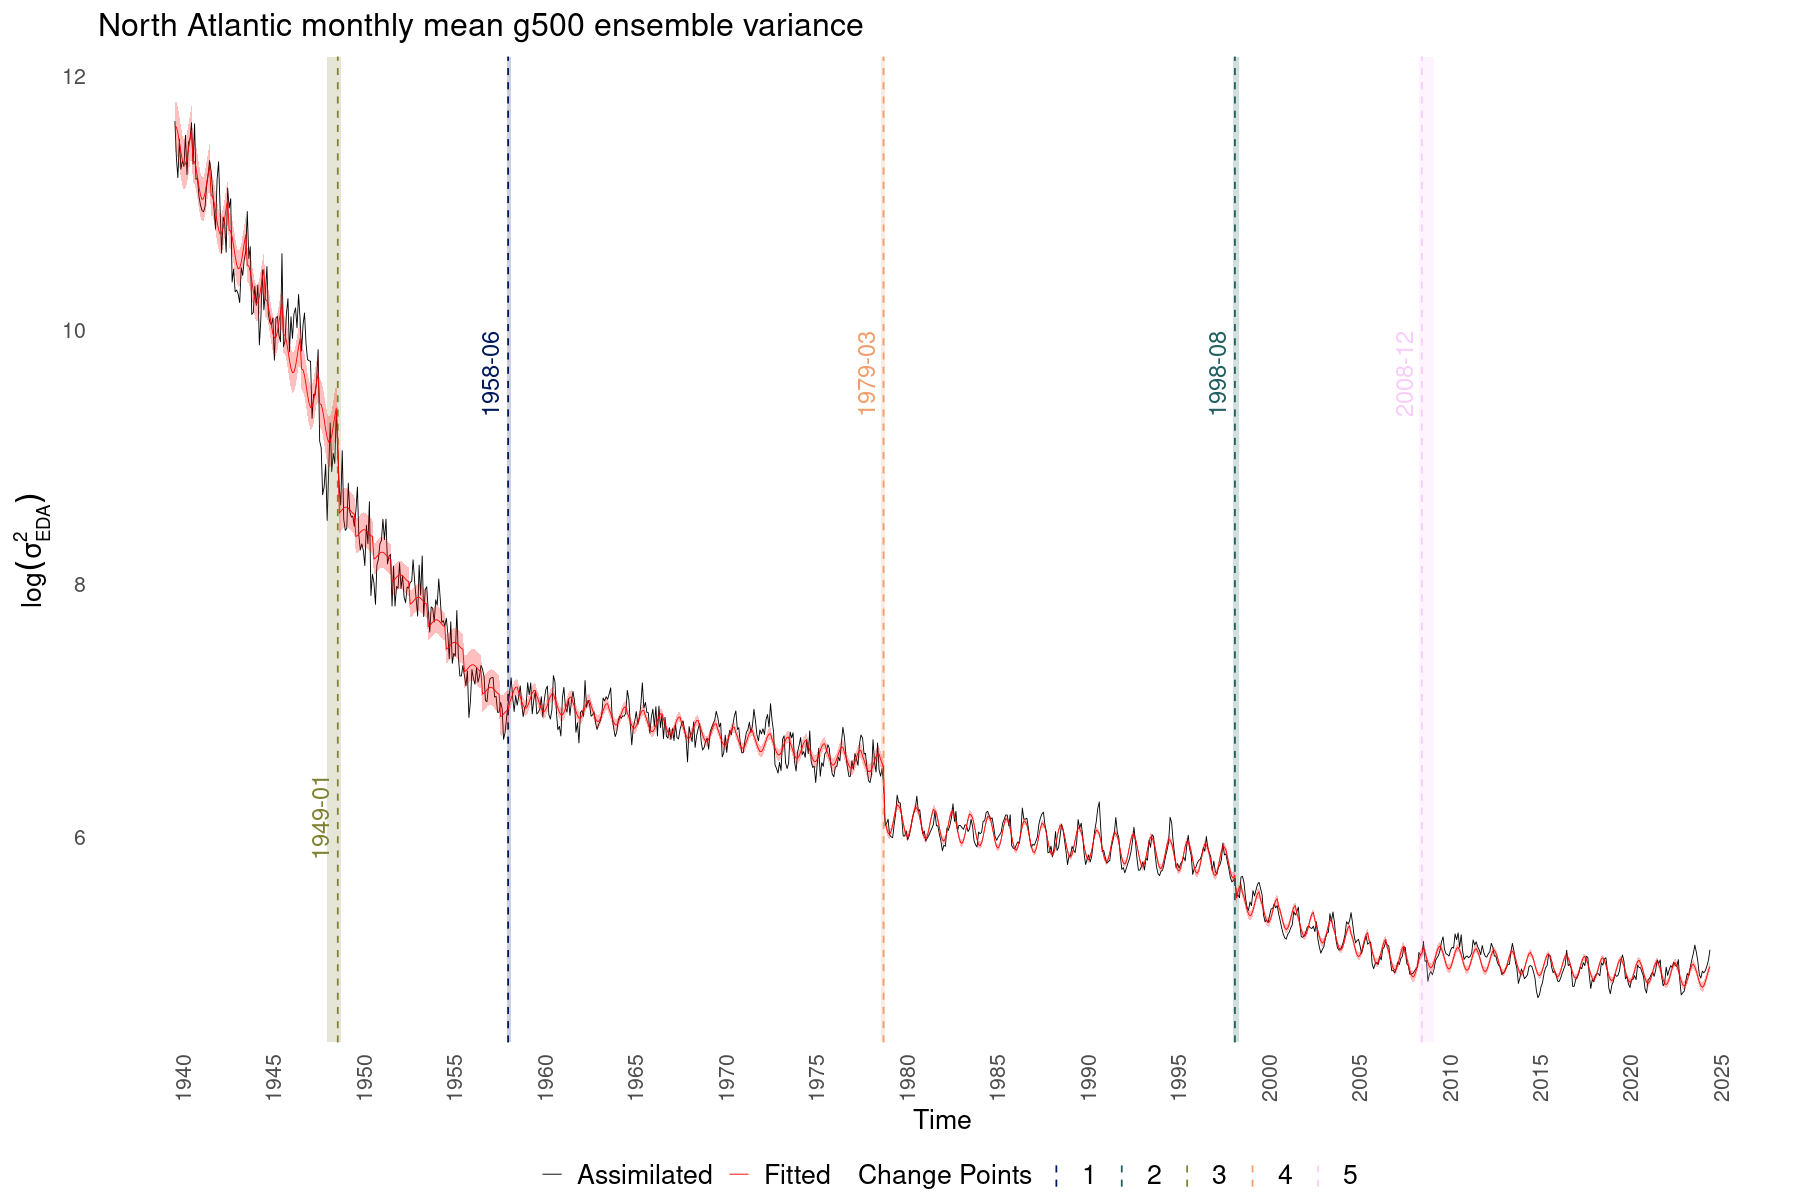

In [46]:
p <- plot_change_points(
    data = combined_dataset,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE
)
p

fitted_layers <- add_fitted_line_ci(lmod_seas_monthly, combined_dataset)
for (layer in fitted_layers) {
    p <- p + layer
}

# Optional: Combine the legends for size and linetype into one "Data" legend
p <- p + guides(
    size = guide_legend(order = 1),
    linetype = guide_legend(order = 2),
    color = guide_legend(order = 3)
)

p

save_plot(p, "ChangePoints.pdf")

p <- p + THEME_PUB_LARGE
p
save_plot(p, "ChangePointsLarge.pdf", width = 9.5, height = 4.25)


### Have a look at the seasonal cycles for each segment and for the whole period
- We want uncertainties for amplitude and phase. 
- We want to use a parametric bootstrap for this (draw parameters from the betas according to their mean and covariance estimates)
- This is only ok if the residuals are approximately normally distributed, do we need to check

Shapiro-Wilk‐Test (standardisierte Residuen): Gut, wenn p>0.05 

	Shapiro-Wilk normality test

data:  std_resid
W = 0.99837, p-value = 0.4554



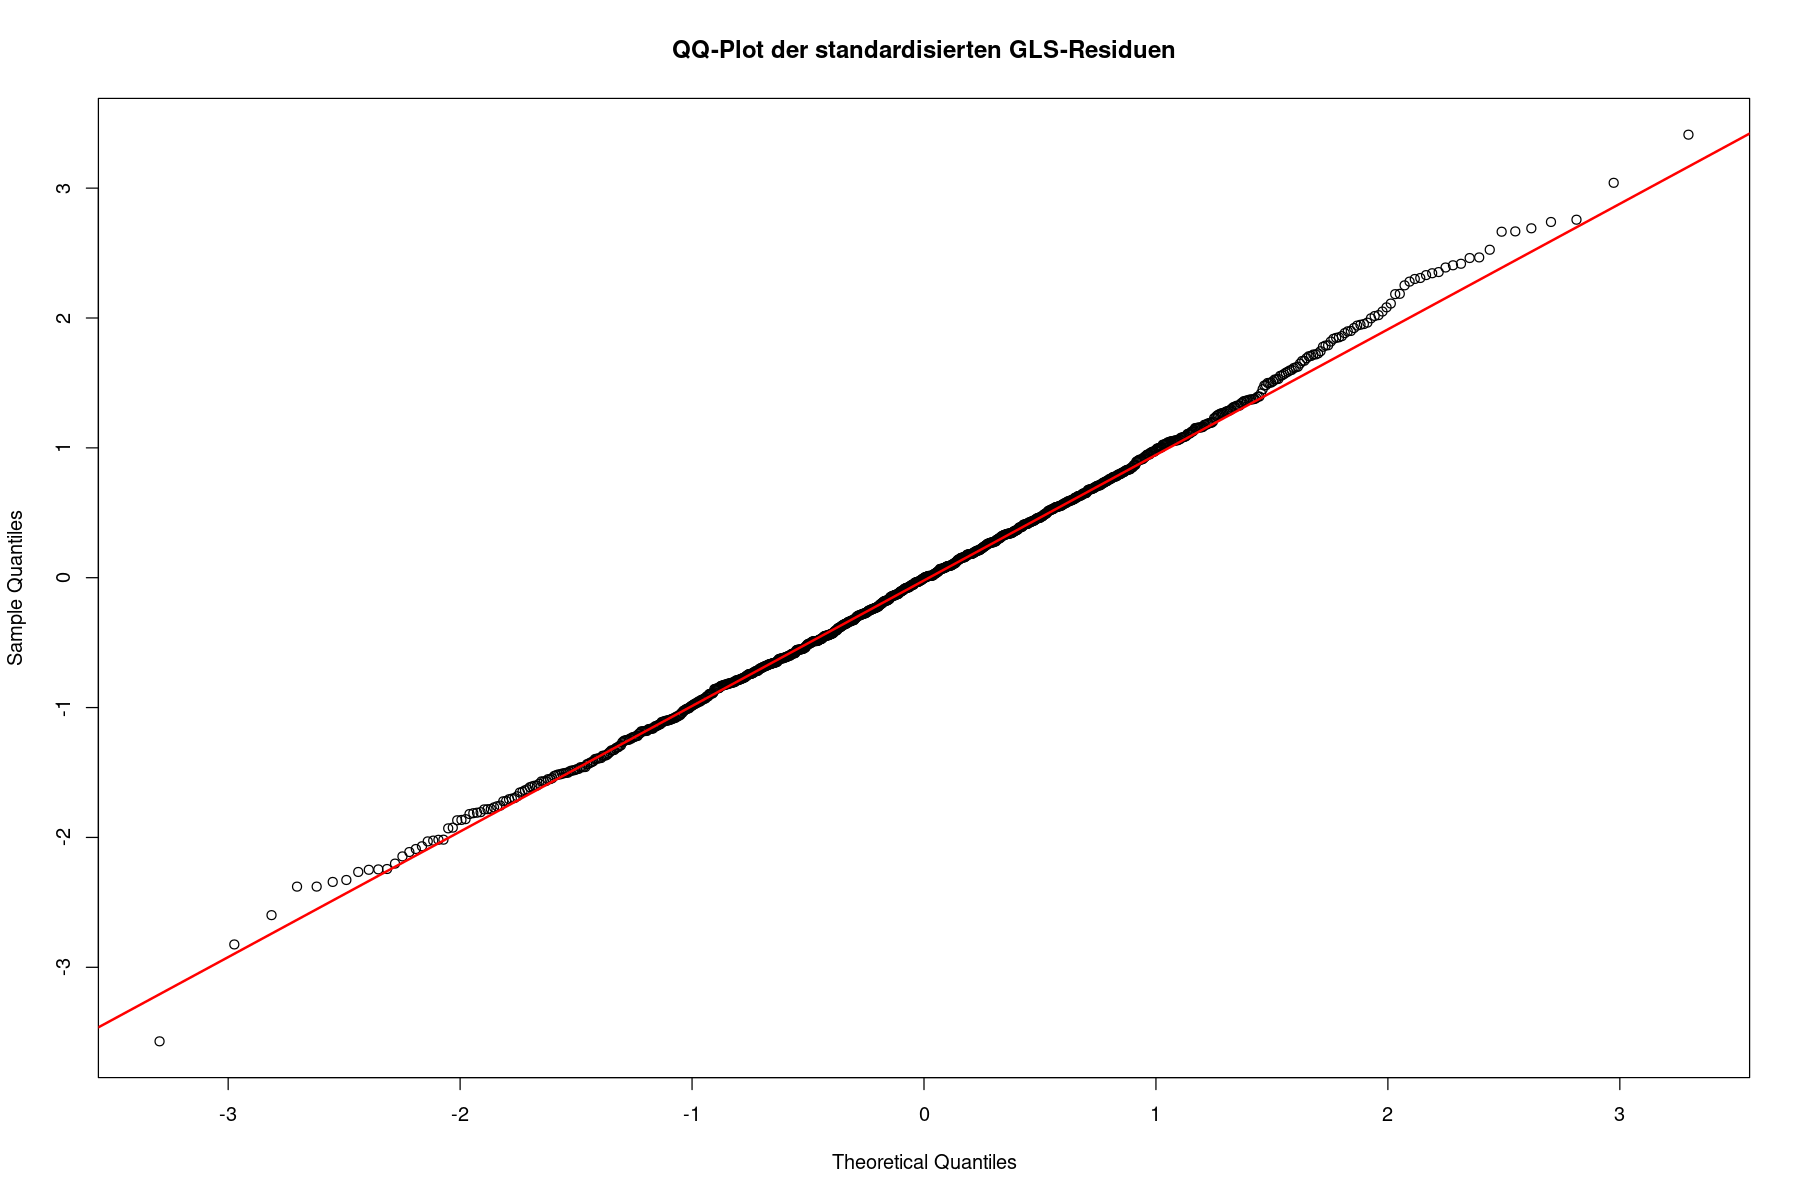

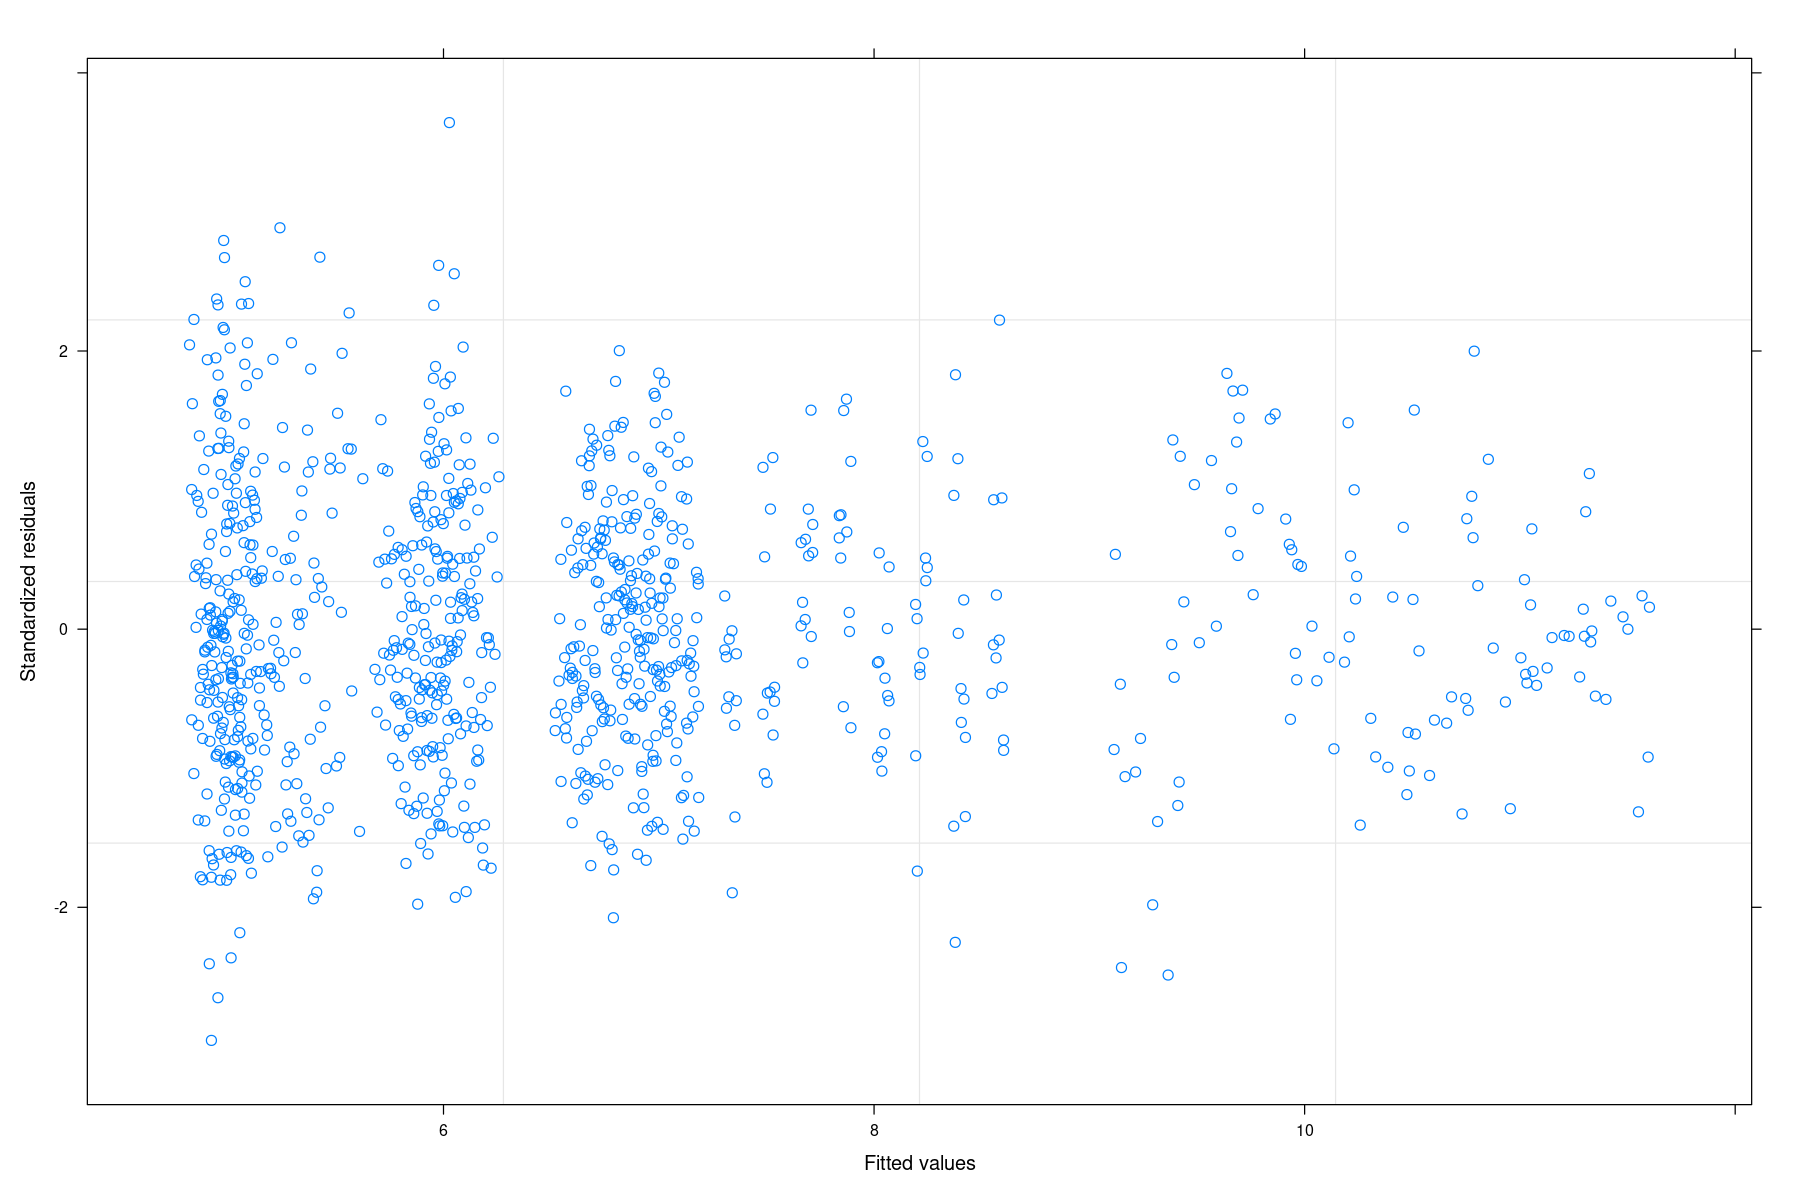

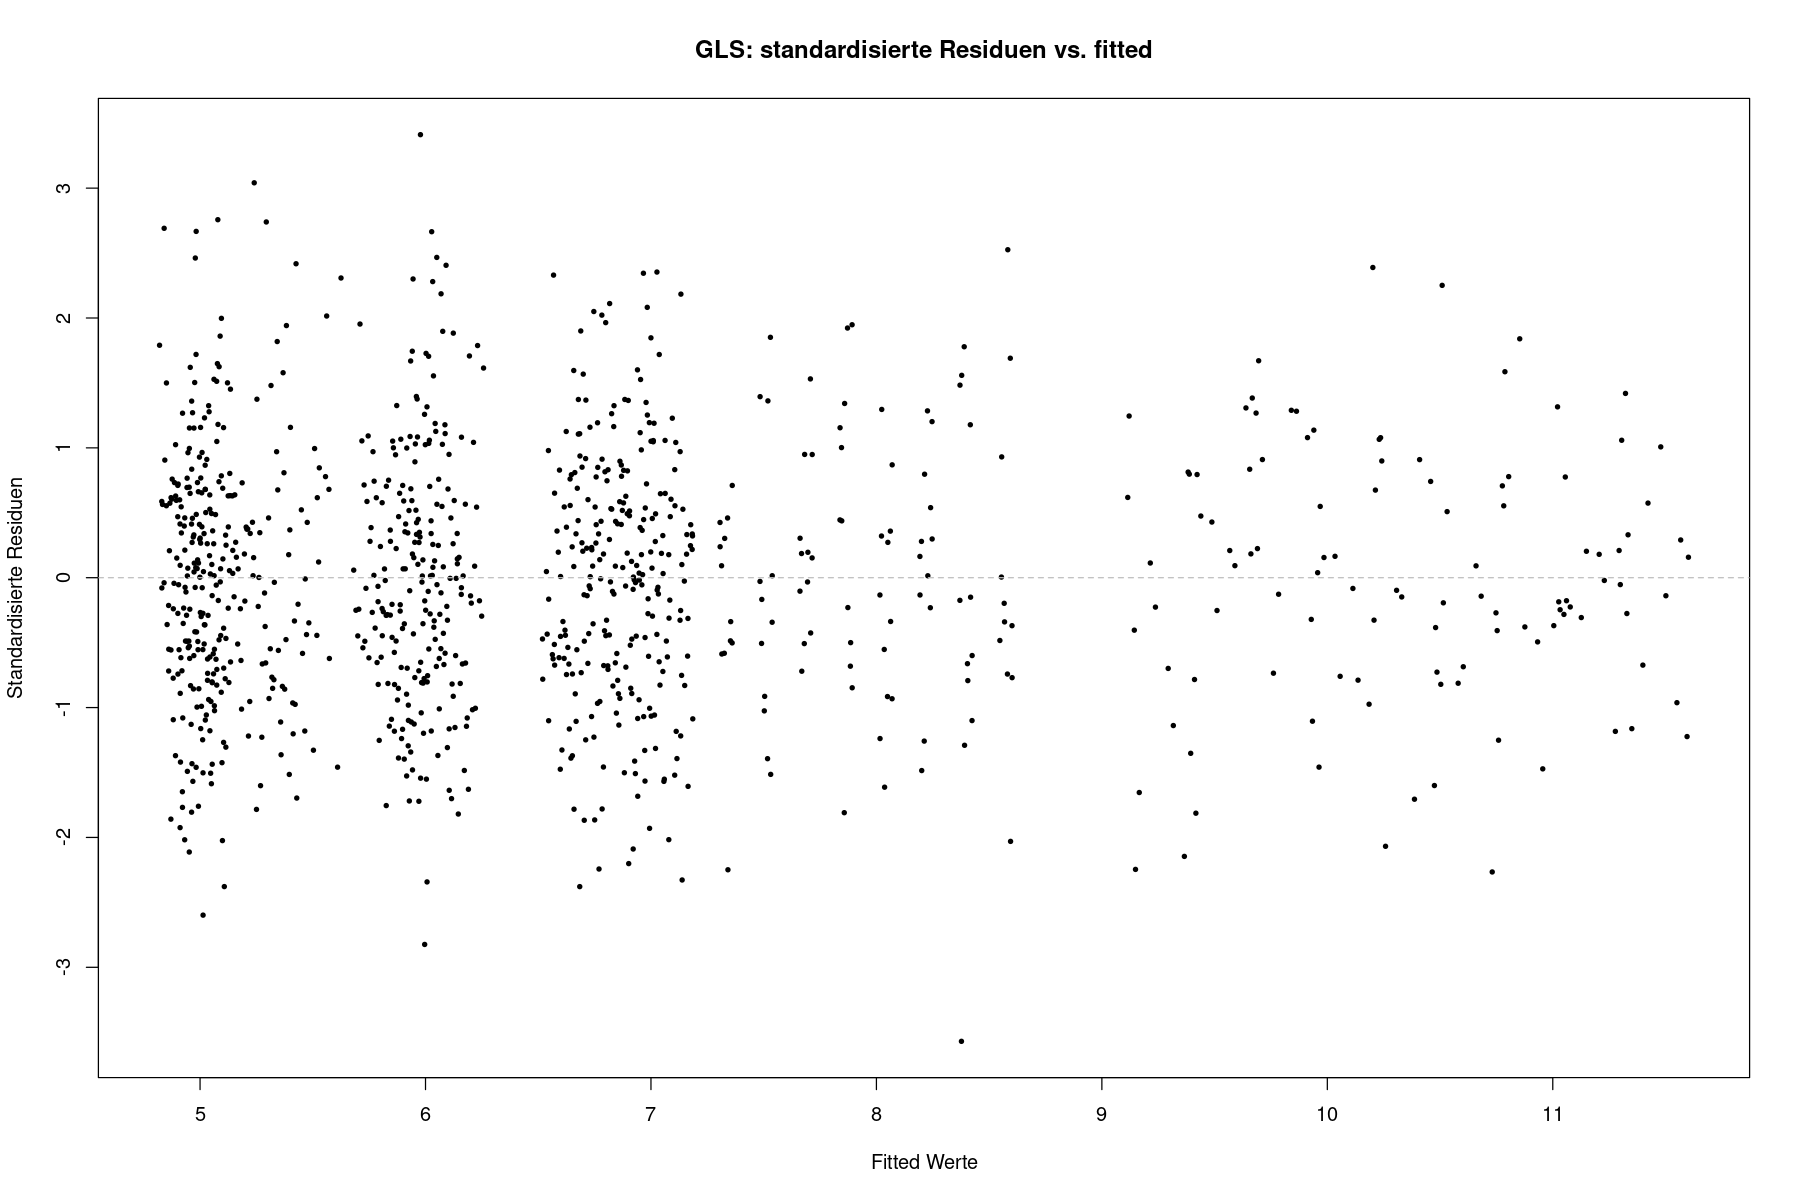

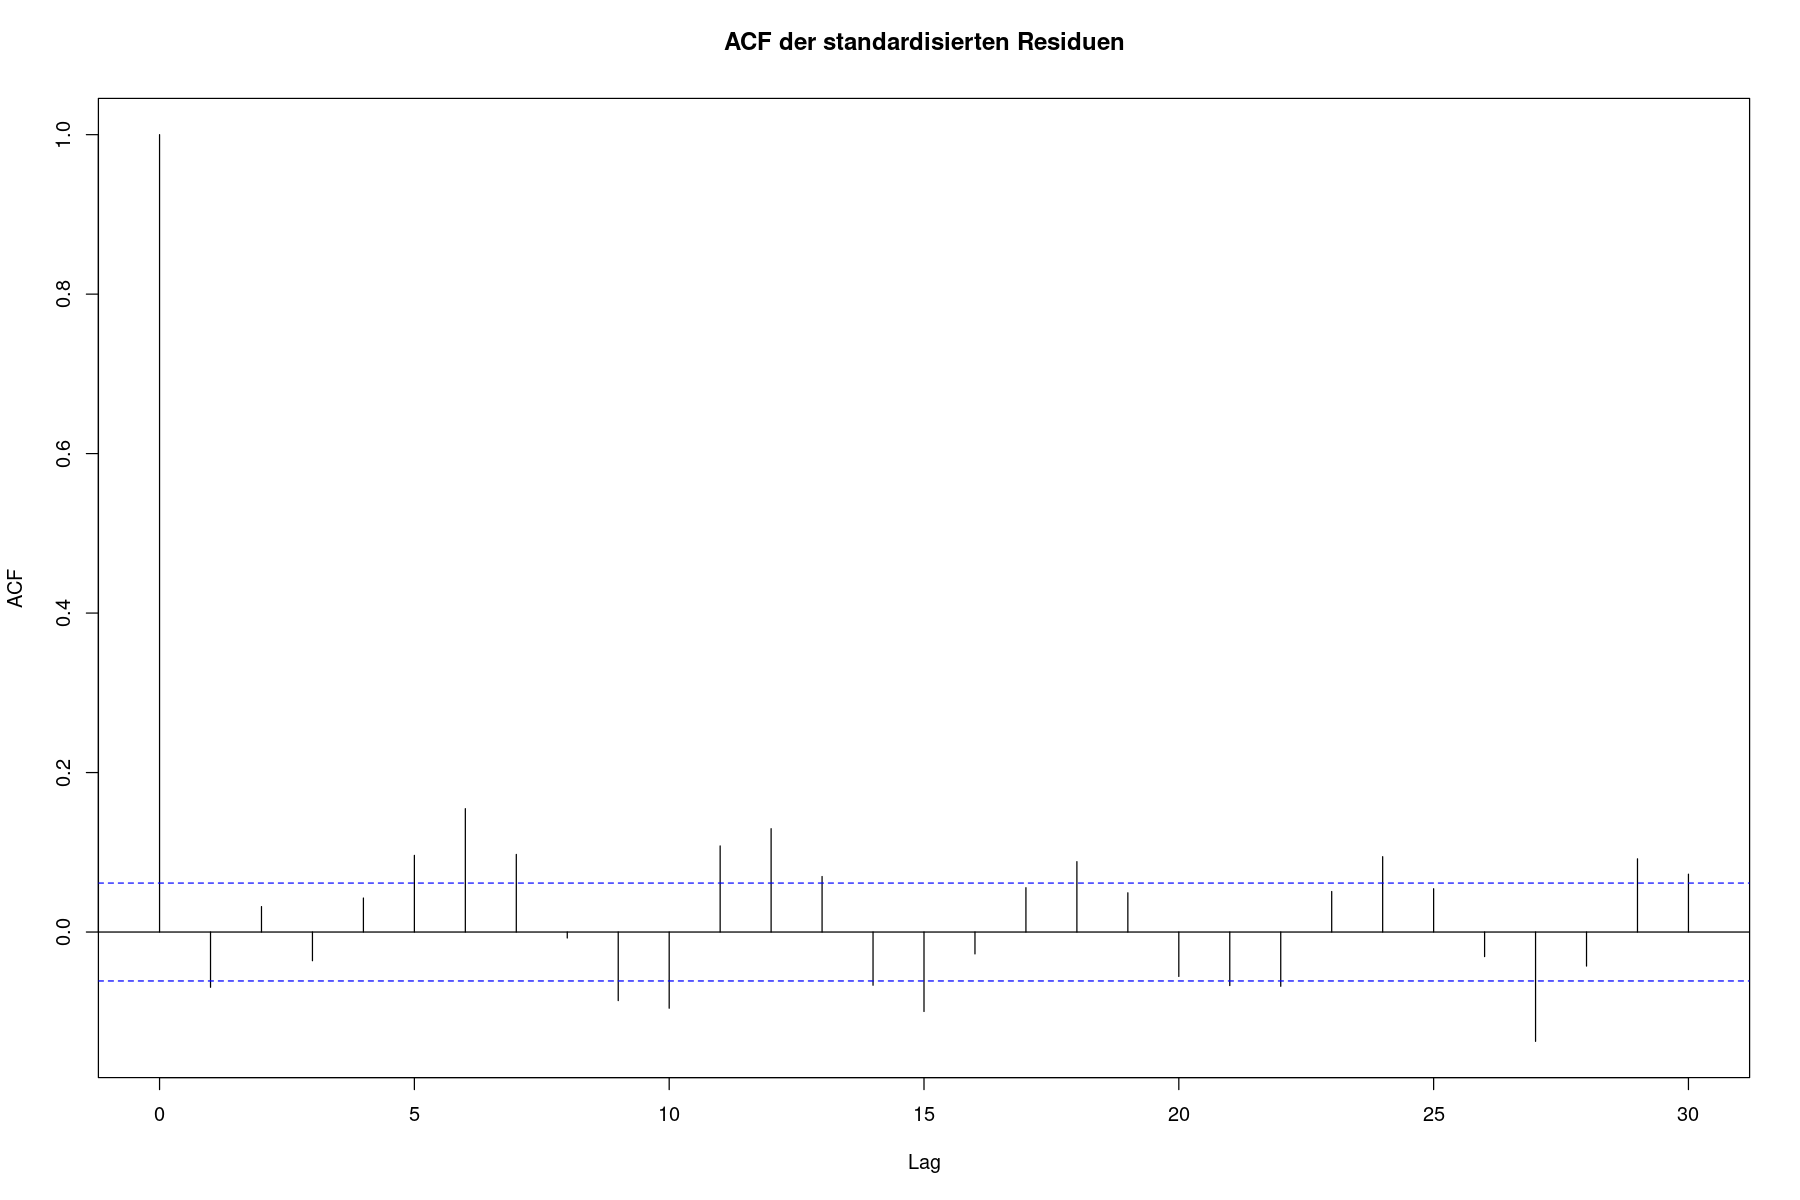

In [53]:
std_resid <- resid(lmod_seas_monthly, type = "normalized")
# “normalized” residuum sind so skaliert, dass sie etwa std-norm verteilt sein sollten.

# 2a) Shapiro-Wilk-Test auf Normalität der standardisierten Residuen
shapiro_std <- shapiro.test(std_resid)
cat("Shapiro-Wilk‐Test (standardisierte Residuen): Gut, wenn p>0.05 \n")
print(shapiro_std)
par(bg = "white")
qqnorm(std_resid, main = "QQ-Plot der standardisierten GLS-Residuen")
qqline(std_resid, col = "red", lwd = 2)
plot(lmod_seas_monthly)
acf(std_resid, main = "ACF der standardisierten Residuen")


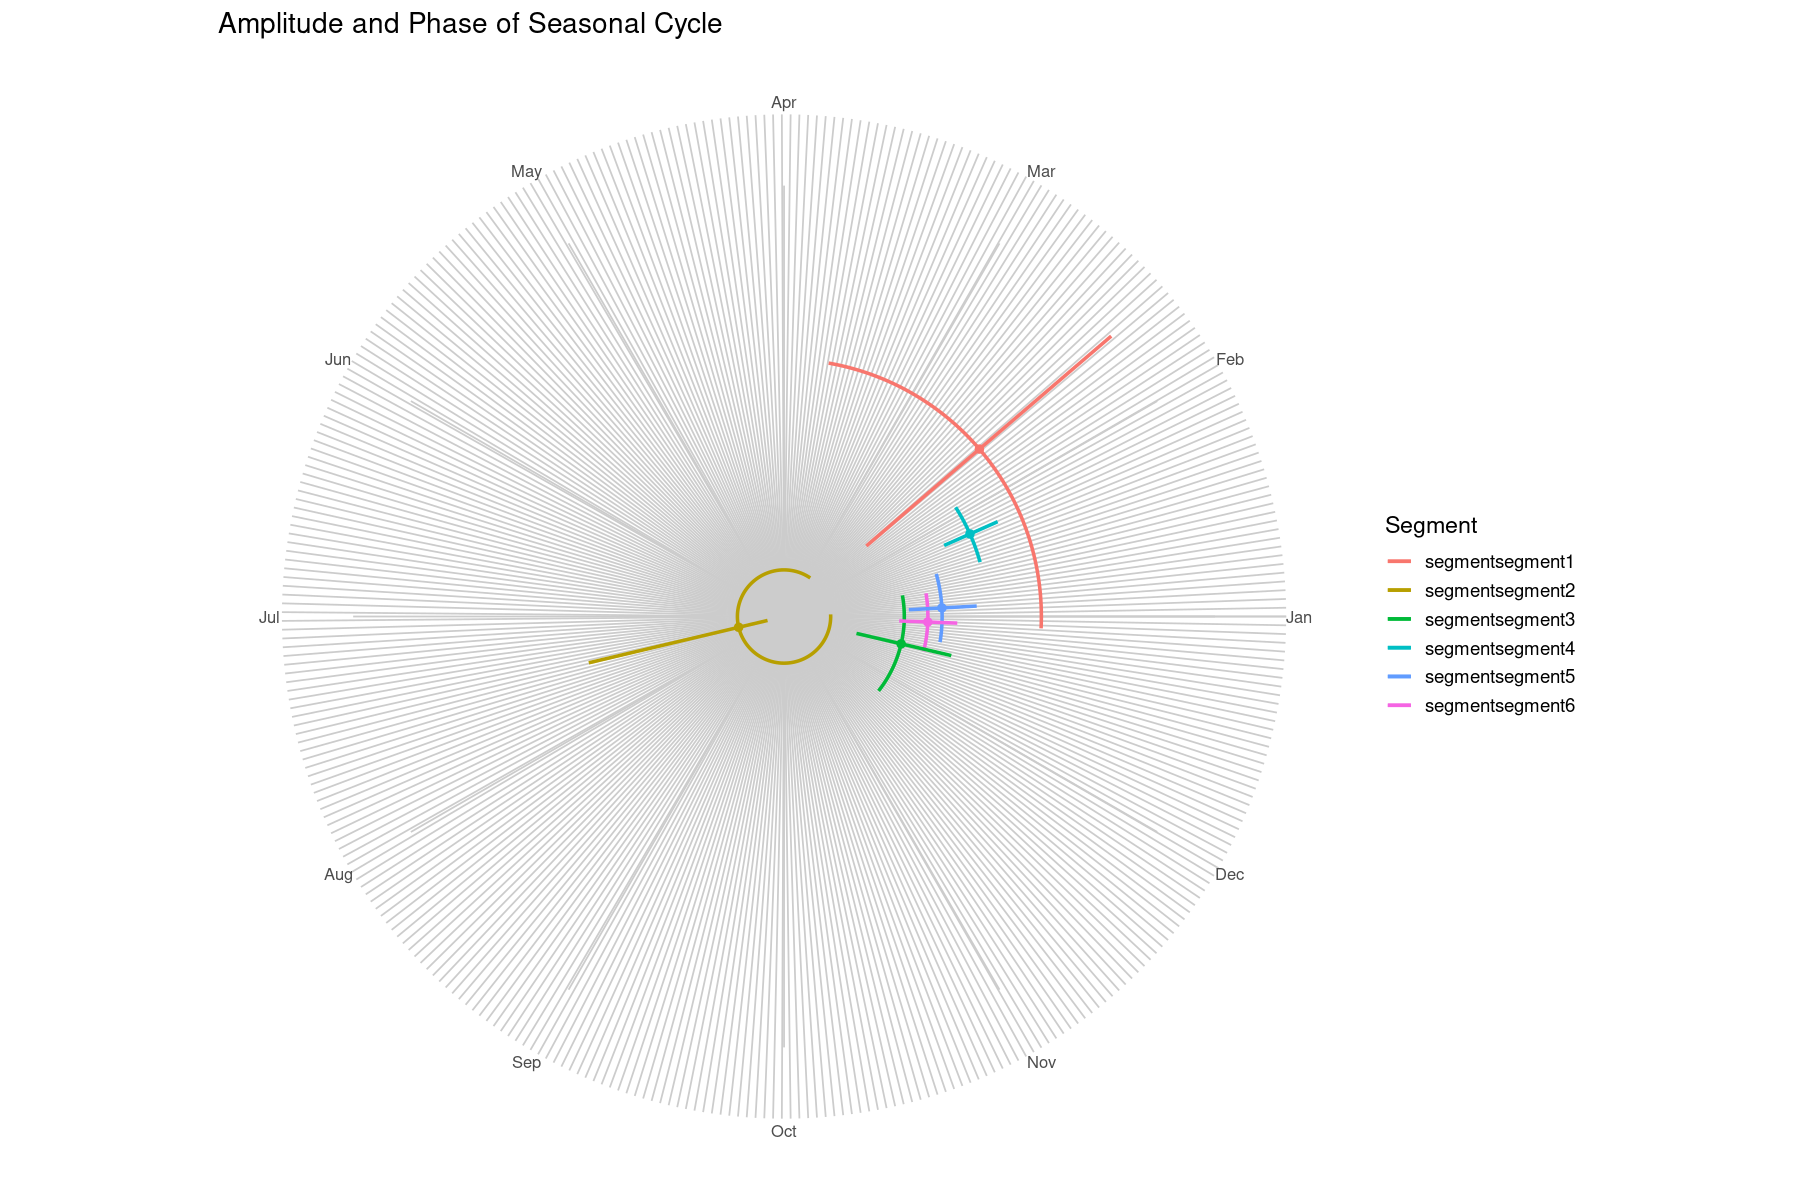

In [69]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Helper: Normiere Winkel auf [0, 2π)
# ─────────────────────────────────────────────────────────────────────────────
to_positive <- function(angle) {
  a <- angle %% (2 * pi)
  ifelse(a < 0, a + 2 * pi, a)
}

# ─────────────────────────────────────────────────────────────────────────────
# 2. Ermittle kleinstes 95%-Intervall auf dem Kreis (kürzeste Bogensegment)
# ─────────────────────────────────────────────────────────────────────────────
circular_CI <- function(angles, alpha = 0.05) {
  # Normiere auf [0, 2π)
  ang <- to_positive(angles)
  n <- length(ang)
  m <- floor((1 - alpha) * n)
  # Sortiere
  ang_sorted <- sort(ang)
  # Erweitere zweifach um 2π für Wrap-Around-Suche
  ang_ext <- c(ang_sorted, ang_sorted + 2 * pi)
  # Finde Fenster der Größe m mit minimalem Bogen
  ends <- ang_ext[(m + 1):(length(ang_ext))]
  starts <- ang_ext[1:(length(ang_ext) - m)]
  widths <- ends - starts
  idx_min <- which.min(widths)
  lower <- starts[idx_min] %% (2 * pi)
  upper <- ends[idx_min] %% (2 * pi)
  list(lower = lower, upper = upper)
}

# ─────────────────────────────────────────────────────────────────────────────
# 3. Bootstrap‐CI‐Berechnung für Amplitude & Phase
# ─────────────────────────────────────────────────────────────────────────────
get_seasonal_CI <- function(gls_model, B = 5000, alpha = 0.05) {
  beta_all <- coef(gls_model)
  varBeta <- gls_model$varBeta
  fe_names <- names(beta_all)

  idx_sin <- grep(":sin_mon$", fe_names)
  idx_cos <- grep(":cos_mon$", fe_names)
  seg_sin <- sub(":sin_mon$", "", fe_names[idx_sin])
  seg_cos <- sub(":cos_mon$", "", fe_names[idx_cos])
  segments <- union(seg_sin, seg_cos)
  idx_sin <- idx_sin[match(segments, seg_sin)]
  idx_cos <- idx_cos[match(segments, seg_cos)]

  beta_sin_hat <- beta_all[idx_sin]
  beta_cos_hat <- beta_all[idx_cos]
  R_hat <- sqrt(beta_sin_hat^2 + beta_cos_hat^2)
  phi_hat <- atan2(beta_sin_hat, beta_cos_hat)
  phi_hat_pos <- to_positive(phi_hat)

  Sigma_sc <- varBeta[c(idx_sin, idx_cos), c(idx_sin, idx_cos)]
  mu_sc <- beta_all[c(idx_sin, idx_cos)]
  BSim <- MASS::mvrnorm(n = B, mu = mu_sc, Sigma = Sigma_sc)

  S <- length(segments)
  beta_sin_boot <- BSim[, 1:S]
  beta_cos_boot <- BSim[, (S + 1):(2 * S)]

  A_boot <- sqrt(beta_sin_boot^2 + beta_cos_boot^2)
  phi_boot_raw <- atan2(beta_sin_boot, beta_cos_boot)

  # Compute CI for R
  CI_R <- apply(A_boot, 2, function(x) quantile(x, probs = c(alpha / 2, 1 - alpha / 2)))

  # Compute circular CI for φ
  CI_phi <- map(seq_len(S), function(j) {
    cb <- phi_boot_raw[, j]
    cci <- circular_CI(cb, alpha = alpha)
    tibble(
      phi_lwr = cci$lower,
      phi_upr = cci$upper
    )
  }) %>% bind_rows()

  tibble(
    segment = segments,
    R       = R_hat,
    phi     = phi_hat_pos,
    R_lwr   = CI_R[1, ],
    R_upr   = CI_R[2, ]
  ) %>%
    bind_cols(CI_phi) %>%
    mutate(
      x       = R * cos(phi),
      y       = R * sin(phi),
      x_lwr   = R_lwr * cos(phi),
      y_lwr   = R_lwr * sin(phi),
      x_upr   = R_upr * cos(phi),
      y_upr   = R_upr * sin(phi)
    )
}

# ─────────────────────────────────────────────────────────────────────────────
# 4. Hilfsfunktionen für den Polar‐Plot
# ─────────────────────────────────────────────────────────────────────────────
make_circle <- function(r, n = 360) {
  tibble(
    theta = seq(0, 2 * pi, length.out = n),
    x     = r * cos(theta),
    y     = r * sin(theta)
  )
}

make_arc_segments <- function(df_ci, n_points = 100) {
  map_df(seq_len(nrow(df_ci)), function(i) {
    R_seg <- df_ci$R[i]
    angle_lo <- df_ci$phi_lwr[i]
    angle_hi <- df_ci$phi_upr[i]
    # Handle wrap-around
    if (angle_hi < angle_lo) angle_hi <- angle_hi + 2 * pi
    angles <- seq(angle_lo, angle_hi, length.out = n_points)
    tibble(
      segment = df_ci$segment[i],
      x_arc   = R_seg * cos(angles),
      y_arc   = R_seg * sin(angles),
      id      = i
    )
  })
}

make_grid <- function(R_max, n_levels = 4) {
  levels <- pretty(c(0, R_max), n = n_levels)
  map_df(levels, make_circle)
}

make_month_lines <- function(R_max) {
  month_angles <- seq(0, 2 * pi - pi / 6, length.out = 12)
  month_labels <- c(
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
  )
  tibble(
    angle   = month_angles,
    x       = 0,
    y       = 0,
    xend    = R_max * cos(angle),
    yend    = R_max * sin(angle),
    label_x = (R_max + 0.05) * cos(angle),
    label_y = (R_max + 0.05) * sin(angle),
    label   = month_labels
  )
}

# ─────────────────────────────────────────────────────────────────────────────
# 5. Plot‐Funktion
# ─────────────────────────────────────────────────────────────────────────────
plot_seasonal_polar <- function(df_ci) {
  R_max <- max(df_ci$R_upr)
  grid_circles <- make_grid(R_max)
  month_lines <- make_month_lines(R_max)
  arc_segments <- make_arc_segments(df_ci)

  ggplot() +
    geom_path(data = grid_circles, aes(x = x, y = y, group = theta), color = "grey80") +
    geom_segment(data = month_lines, aes(x = x, y = y, xend = xend, yend = yend), color = "grey80") +
    geom_text(data = month_lines, aes(x = label_x, y = label_y, label = label), size = 3.5, color = "grey30") +
    geom_path(data = arc_segments, aes(x = x_arc, y = y_arc, group = id, color = segment), size = 1) +
    geom_segment(data = df_ci, aes(x = x_lwr, y = y_lwr, xend = x_upr, yend = y_upr, color = segment), size = 1) +
    geom_point(data = df_ci, aes(x = x, y = y, color = segment, size = segment == "global"), show.legend = FALSE) +
    scale_size_manual(values = c("TRUE" = 3.5, "FALSE" = 2)) +
    coord_equal() +
    theme_minimal(base_size = 14) +
    theme(
      axis.title      = element_blank(),
      axis.text       = element_blank(),
      axis.ticks      = element_blank(),
      panel.grid      = element_blank(),
      legend.position = "right"
    ) +
    labs(title = "Amplitude and Phase of Seasonal Cycle", color = "Segment")
}

# ─────────────────────────────────────────────────────────────────────────────
# 6. Beispielaufruf
# ─────────────────────────────────────────────────────────────────────────────
df_ci <- get_seasonal_CI(lmod_seas_monthly, B = 5000)
plot_seasonal_polar(df_ci)


In [65]:
df_ci


segment,R,phi,R_lwr,R_upr,phi_lwr,phi_upr,x,y,x_lwr,y_lwr,x_upr,y_upr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
segmentsegment1,0.15372605,0.70861133,0.06686835,0.2581394,-0.009376792,1.4198689,0.11671901,0.100041844,0.05077089,0.043516589,0.1959965,0.167991938
segmentsegment2,0.02786608,-2.90898026,0.01028856,0.1172207,-3.063840838,3.0665260,-0.02711558,-0.006423699,-0.01001146,-0.002371722,-0.1140636,-0.027021746
segmentsegment3,0.07184360,-0.22929928,0.04424804,0.1024953,-0.651356481,0.1902632,0.06996316,-0.016329705,0.04308989,-0.010057367,0.0998126,-0.023296694
segmentsegment4,0.12152841,0.41792176,0.10407471,0.1395981,0.273557143,0.5638335,0.11106899,0.049323759,0.09511745,0.042239964,0.1275835,0.056657579
segmentsegment5,0.09443372,0.05446307,0.07442240,0.1152626,-0.159191239,0.2754589,0.09429370,0.005140608,0.07431205,0.004051268,0.1150917,0.006274451
segmentsegment6,0.08593959,-0.03809731,0.06939210,0.1042752,-0.243062250,0.1642585,0.08587723,-0.003273276,0.06934175,-0.002643013,0.1041995,-0.003971644


In [47]:
coefs_all <- coef(lmod_seas_monthly)
V_all <- vcov(lmod_seas_monthly)
segments <- levels(combined_dataset$segment)

df_segs <- tibble(segment = segments) %>%
    rowwise() %>%
    mutate(
        name_sin = paste0("segment", segment, ":sin_mon"),
        name_cos = paste0("segment", segment, ":cos_mon"),
        beta_sin = coefs_all[name_sin],
        beta_cos = coefs_all[name_cos],
        var_sin = V_all[name_sin, name_sin],
        var_cos = V_all[name_cos, name_cos],
        cov_sc = V_all[name_sin, name_cos]
    ) %>%
    ungroup()


In [54]:
compute_amp_phase <- function(
    beta_sin, beta_cos, var_sin, var_cos, cov_sc) {
    R <- sqrt(beta_sin^2 + beta_cos^2)
    theta <- atan2(beta_cos, beta_sin)
    var_R <- if (R > 0) {
        (beta_sin^2 * var_sin + beta_cos^2 * var_cos +
            2 * beta_sin * beta_cos * cov_sc) / (R^2)
    } else {
        0
    }
    se_R <- sqrt(var_R)
    denom_theta <- (beta_sin^2 + beta_cos^2)^2
    var_theta <- if (denom_theta > 0) {
        (beta_sin^2 * var_cos + beta_cos^2 * var_sin -
            2 * beta_sin * beta_cos * cov_sc) / denom_theta
    } else {
        0
    }
    se_theta <- sqrt(var_theta)
    t_max <- (pi / 2 - theta) / (pi / 6)
    phase_mon <- (t_max %% 12)
    se_phase <- (6 / pi) * se_theta
    tibble(
        R = R,
        theta_rad = theta,
        phase_month = phase_mon,
        se_R = se_R,
        se_phase_mon = se_phase
    )
}


In [55]:
df_segs2 <- df_segs %>%
    mutate(result = pmap(
        list(beta_sin, beta_cos, var_sin, var_cos, cov_sc),
        ~ compute_amp_phase(..1, ..2, ..3, ..4, ..5)
    )) %>%
    unnest(result)


In [56]:
coefs_all_global <- coef(seasonal_model)
beta_sin_all <- coefs_all_global["sin_mon"]
beta_cos_all <- coefs_all_global["cos_mon"]
V_all_global <- vcov(seasonal_model)
var_sin_all <- V_all_global["sin_mon", "sin_mon"]
var_cos_all <- V_all_global["cos_mon", "cos_mon"]
cov_sc_all <- V_all_global["sin_mon", "cos_mon"]

df_global <- compute_amp_phase(
    beta_sin  = beta_sin_all,
    beta_cos  = beta_cos_all,
    var_sin   = var_sin_all,
    var_cos   = var_cos_all,
    cov_sc    = cov_sc_all
) %>%
    mutate(segment = "ALL") %>%
    select(segment, R, phase_month, se_R, se_phase_mon)


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Phase: Month of Maximum (continuous 0–12)' in 'mbcsToSbcs': Punkt ersetzt <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Phase: Month of Maximum (continuous 0–12)' in 'mbcsToSbcs': Punkt ersetzt <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Phase: Month of Maximum (continuous 0–12)' in 'mbcsToSbcs': Punkt ersetzt <93>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für '(Global (“ALL”) and Per‐Segment Estimates)' in 'mbcsToSbcs': Punkt ersetzt <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für '(Global (“ALL”) and Per‐Segment Estimates)' in 'mbcsToSbcs': Punkt ersetzt <80>”
Warning message in grid.Call(C_textBounds, as.graphic

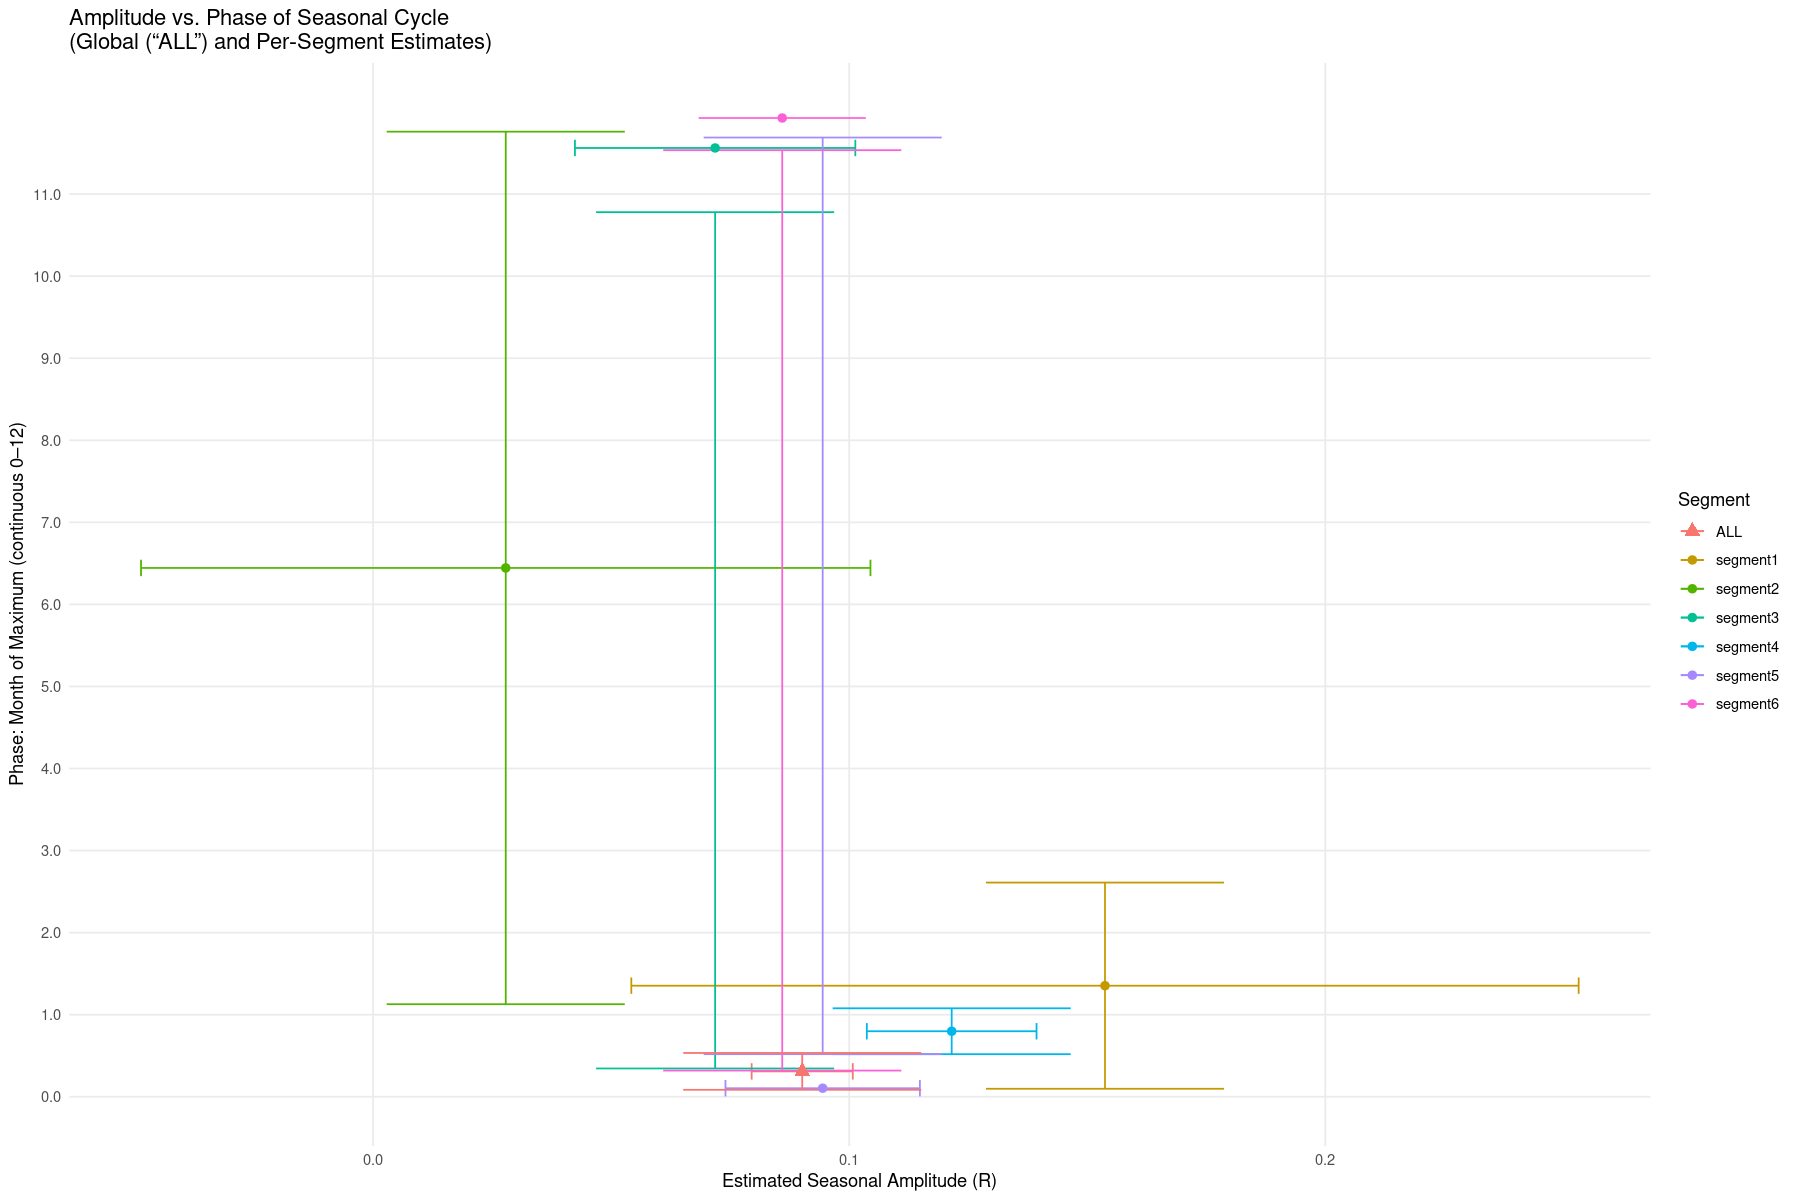

In [59]:
df_plot <- df_segs2 %>%
    select(segment, R, phase_month, se_R, se_phase_mon) %>%
    bind_rows(df_global) %>%
    mutate(
        tval    = qt(0.975, df = nrow(combined_dataset) - length(coef(seasonal_model))),
        amp_lwr = R - tval * se_R,
        amp_upr = R + tval * se_R,
        phs_lwr = phase_month - tval * se_phase_mon,
        phs_upr = phase_month + tval * se_phase_mon
    ) %>%
    mutate(
        phs_lwr = (phs_lwr %% 12),
        phs_upr = (phs_upr %% 12)
    )

ggplot(df_plot, aes(x = R, y = phase_month, color = segment)) +
    geom_errorbarh(aes(xmin = amp_lwr, xmax = amp_upr), height = 0.2) +
    geom_errorbar(aes(ymin = phs_lwr, ymax = phs_upr), width = 0.05) +
    geom_point(size = 2) +
    geom_point(
        data = filter(df_plot, segment == "ALL"),
        aes(x = R, y = phase_month),
        shape = 17, size = 3
    ) +
    scale_y_continuous(
        breaks = seq(0, 11, by = 1),
        limits = c(0, 12),
        labels = function(x) sprintf("%.1f", x)
    ) +
    labs(
        x = "Estimated Seasonal Amplitude (R)",
        y = "Phase: Month of Maximum (continuous 0–12)",
        color = "Segment",
        title = "Amplitude vs. Phase of Seasonal Cycle\n(Global (“ALL”) and Per‐Segment Estimates)"
    ) +
    theme_minimal() +
    theme(
        legend.position = "right",
        panel.grid.minor = element_blank()
    )


In [60]:
df_plot_polar <- df_plot %>%
  mutate(
    theta        = (2 * pi * phase_month) / 12,
    theta_lwr    = (2 * pi * phs_lwr) / 12,
    theta_upr    = (2 * pi * phs_upr) / 12,
    x            = R * cos(theta),
    y            = R * sin(theta),
    x_lwr        = amp_lwr * cos(theta),
    y_lwr        = amp_lwr * sin(theta),
    x_upr        = amp_upr * cos(theta),
    y_upr        = amp_upr * sin(theta),
    is_global    = segment == "ALL"
  ) %>%
  mutate(
    theta_lwr_fixed = if_else(theta_lwr > theta_upr, theta_upr, theta_lwr),
    theta_upr_fixed = if_else(theta_lwr > theta_upr, theta_lwr, theta_upr)
  )


In [61]:
arc_segments <- df_plot_polar %>%
    mutate(
        id = row_number(),
        theta_lwr_fixed = theta_lwr_fixed %% (2 * pi),
        theta_upr_fixed = theta_upr_fixed %% (2 * pi),
        theta_diff = (theta_upr_fixed - theta_lwr_fixed) %% (2 * pi)
    ) %>%
    rowwise() %>%
    mutate(
        arc_points = list({
            n_points <- 100
            arc_seq <- if (theta_diff > pi) {
                seq(theta_upr_fixed, theta_lwr_fixed + 2 * pi, length.out = n_points) %% (2 * pi)
            } else {
                seq(theta_lwr_fixed, theta_upr_fixed, length.out = n_points)
            }
            tibble(
                theta_arc = arc_seq,
                R_arc = R,
                x_arc = R * cos(arc_seq),
                y_arc = R * sin(arc_seq)
            )
        })
    ) %>%
    unnest(arc_points) %>%
    ungroup()


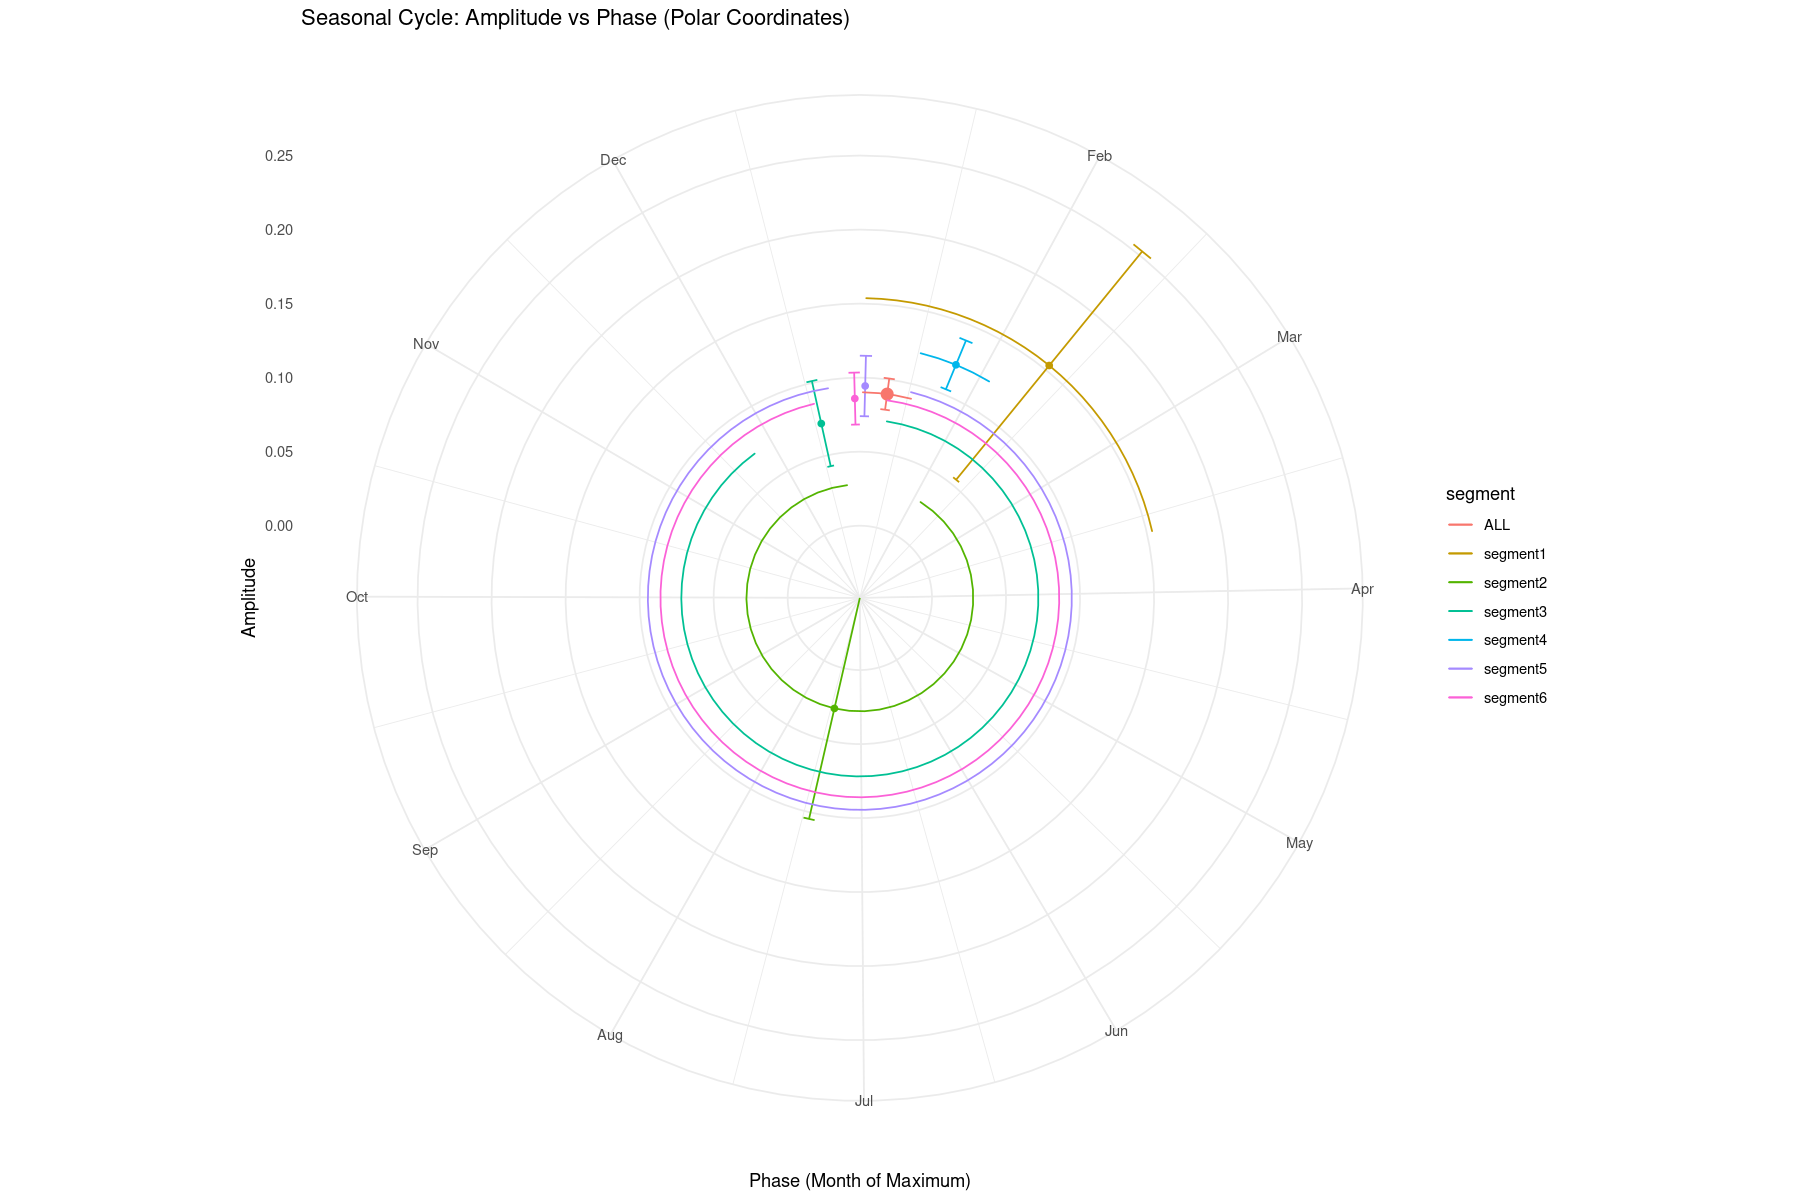

In [62]:
ggplot(df_plot_polar, aes(x = theta, y = R, color = segment)) +
    geom_point(aes(size = is_global), show.legend = FALSE) +
    geom_errorbar(aes(ymin = amp_lwr, ymax = amp_upr), width = 0.05) +
    geom_segment(aes(
        x = theta_lwr_fixed, xend = theta_upr_fixed,
        y = R, yend = R
    ), lineend = "round") +
    scale_size_manual(values = c("TRUE" = 3, "FALSE" = 1.5)) +
    scale_x_continuous(
        breaks = seq(0, 2 * pi - 1e-6, by = pi / 6),
        labels = c(
            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
        )
    ) +
    coord_polar(theta = "x", start = 0, direction = 1) +
    labs(
        title = "Seasonal Cycle: Amplitude vs Phase (Polar Coordinates)",
        x = "Phase (Month of Maximum)",
        y = "Amplitude"
    ) +
    theme_minimal()


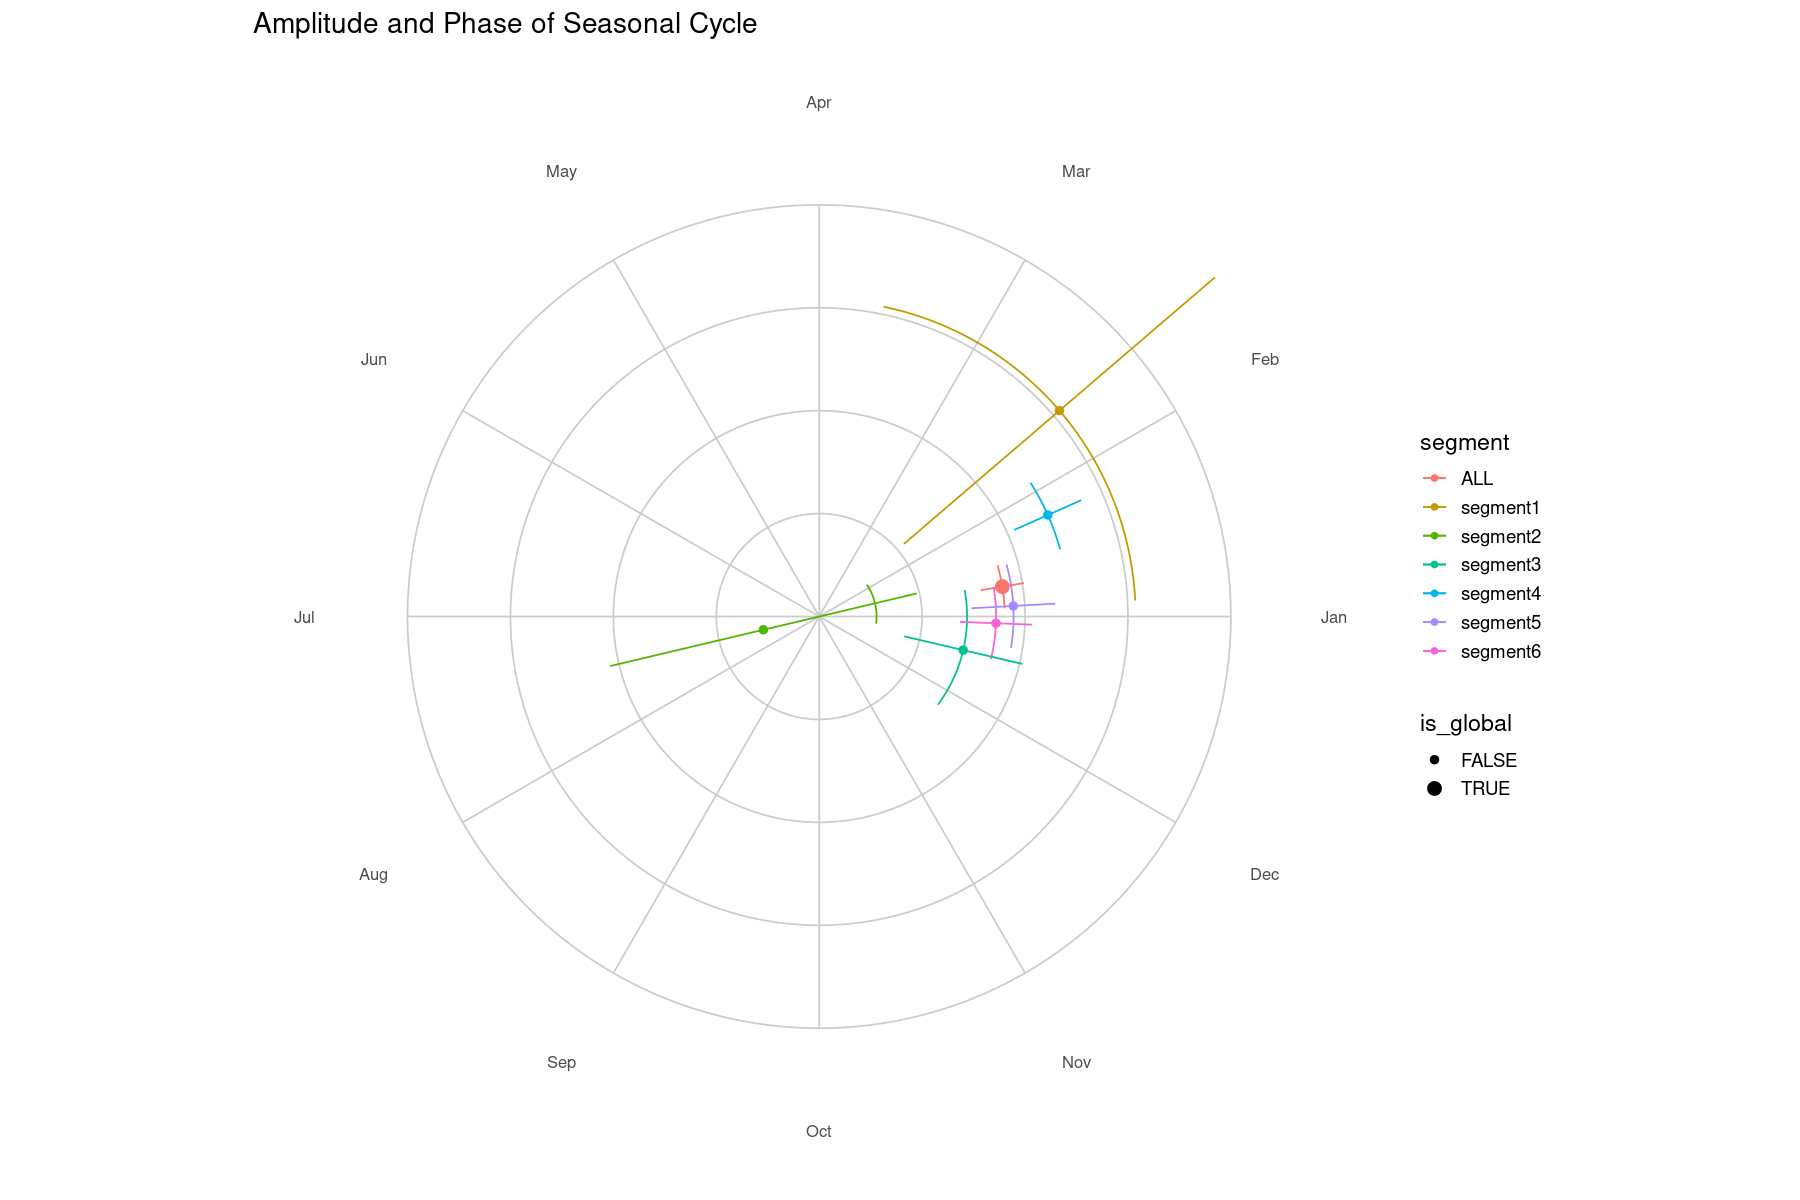

In [63]:
make_circle <- function(r, n = 360) {
    tibble(
        theta = seq(0, 2 * pi, length.out = n),
        x = r * cos(theta),
        y = r * sin(theta),
        r = r
    )
}

amplitude_levels <- pretty(range(df_plot_polar$R), n = 4)
grid_circles <- purrr::map_df(amplitude_levels, make_circle)
month_angles <- seq(0, 2 * pi - pi / 6, length.out = 12)
month_labels <- c(
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
)

month_lines <- tibble(
    angle = month_angles,
    x = 0,
    y = 0,
    xend = max(amplitude_levels) * cos(angle),
    yend = max(amplitude_levels) * sin(angle),
    label_x = (max(amplitude_levels) + 0.05) * cos(angle),
    label_y = (max(amplitude_levels) + 0.05) * sin(angle),
    label = month_labels
)
ggplot() +
    # Grid circles
    geom_path(data = grid_circles, aes(x = x, y = y, group = r), color = "grey80") +

    # Month spokes
    geom_segment(
        data = month_lines,
        aes(x = x, y = y, xend = xend, yend = yend),
        color = "grey80"
    ) +

    # Month labels
    geom_text(
        data = month_lines,
        aes(x = label_x, y = label_y, label = label),
        size = 3.5, color = "grey30"
    ) +

    # Phase error arcs
    geom_path(data = arc_segments, aes(x = x_arc, y = y_arc, group = id, color = segment)) +

    # Error segments
    geom_segment(
        data = df_plot_polar,
        aes(x = x_lwr, y = y_lwr, xend = x_upr, yend = y_upr, color = segment),
        inherit.aes = FALSE
    ) +

    # Central points
    geom_point(
        data = df_plot_polar,
        aes(x = x, y = y, color = segment, size = is_global)
    ) +
    scale_size_manual(values = c("TRUE" = 3.5, "FALSE" = 2)) +
    coord_equal() +
    theme_minimal(base_size = 14) +
    theme(
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        legend.position = "right"
    ) +
    labs(title = "Amplitude and Phase of Seasonal Cycle")


In [32]:
residuals <- residuals(seasonal_model)
fitted_vals <- fitted(seasonal_model)
n <- length(residuals)
e <- residuals
num_dw <- sum((e[-1] - e[-n])^2) # Summe über (e_i - e_{i-1})^2, i=2..n
den_dw <- sum(e^2) # Summe über e_i^2
DW_stat <- num_dw / den_dw

cat(sprintf("Durbin‐Watson‐Statistik: DW = %.4f\n", DW_stat))
cat("  (Nahe 2 → keine Autokorrelation; < 2 → positive Autokorr.; > 2 → negative Autokorr.)\n\n")


Durbin‐Watson‐Statistik: DW = 1.0807
  (Nahe 2 → keine Autokorrelation; < 2 → positive Autokorr.; > 2 → negative Autokorr.)



# Watch our for Autocorrelation!
**All models fitted exhibit autocorrelation to a significant degree. This comes as no surprise, but demands choosing ARIMA over ordinary least squares**

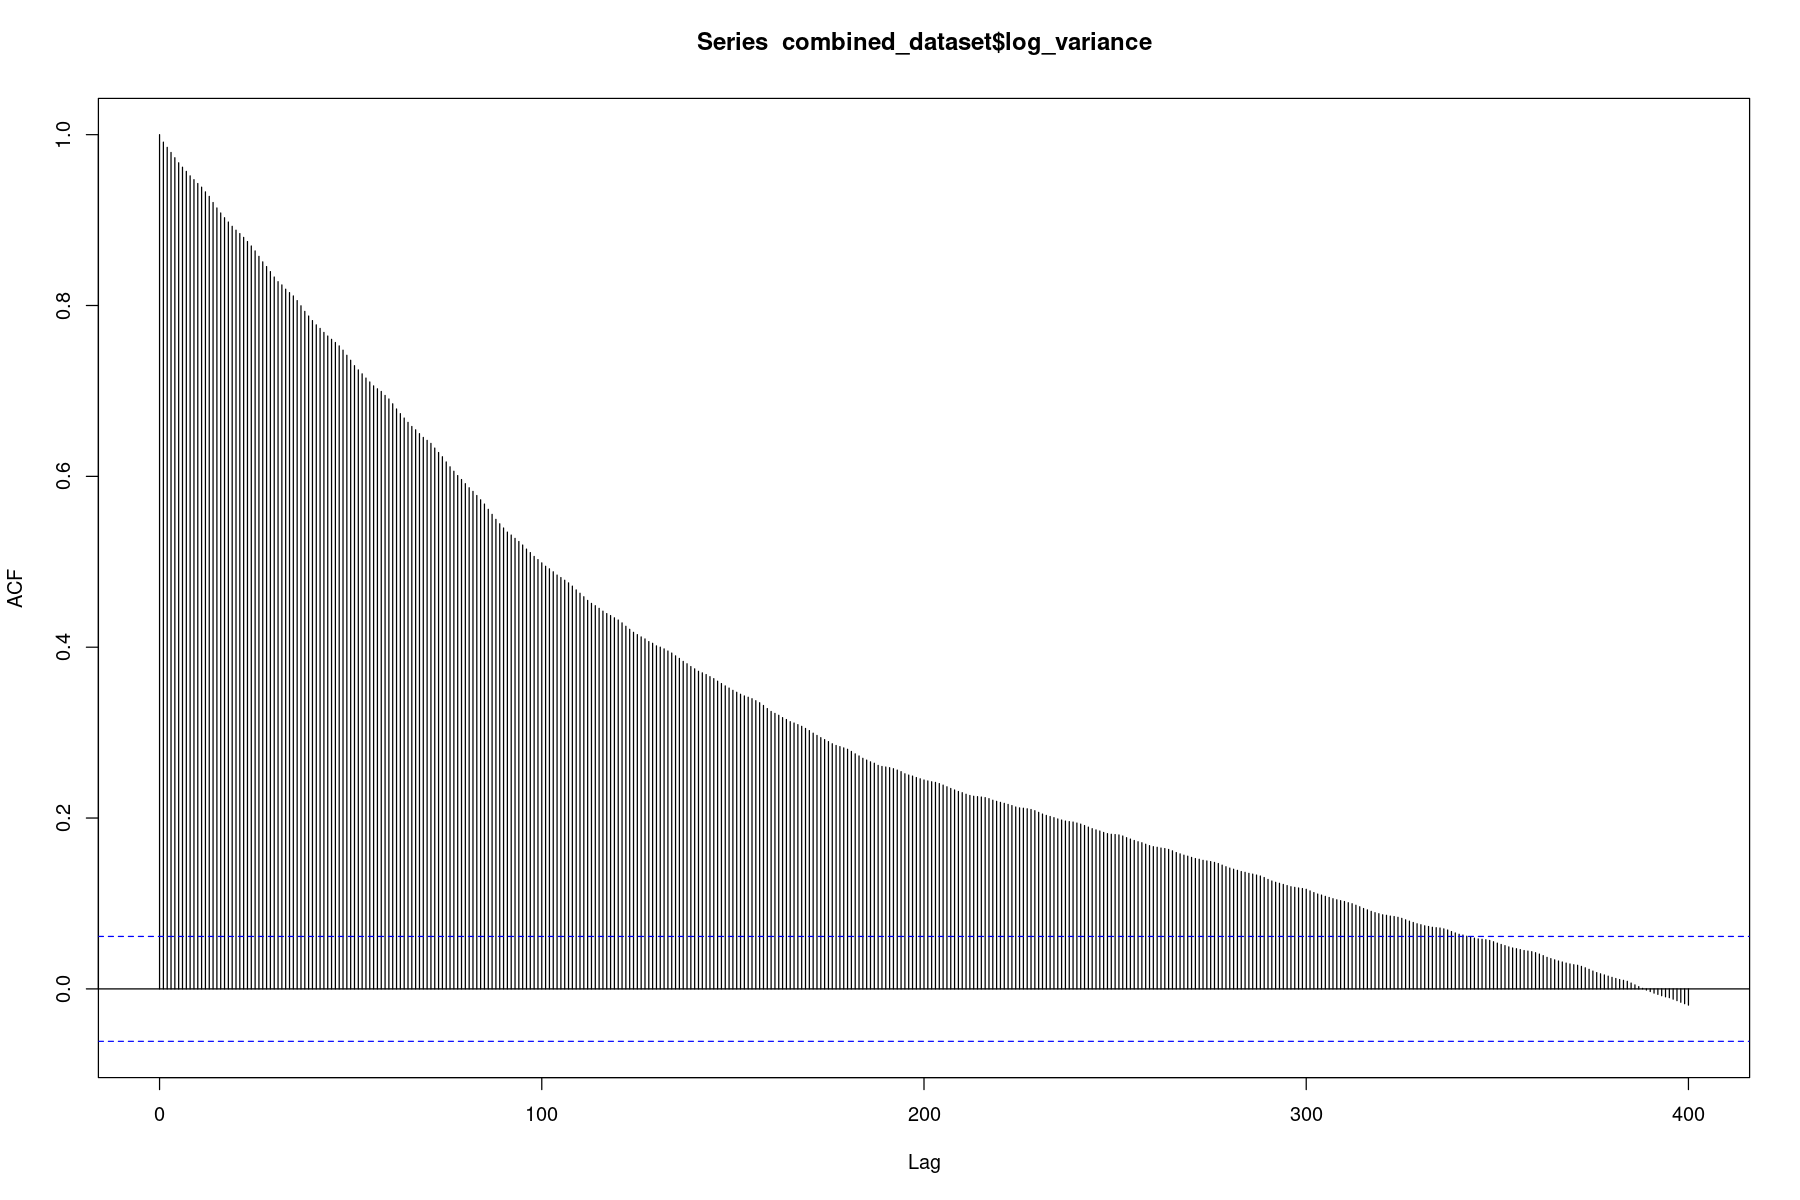

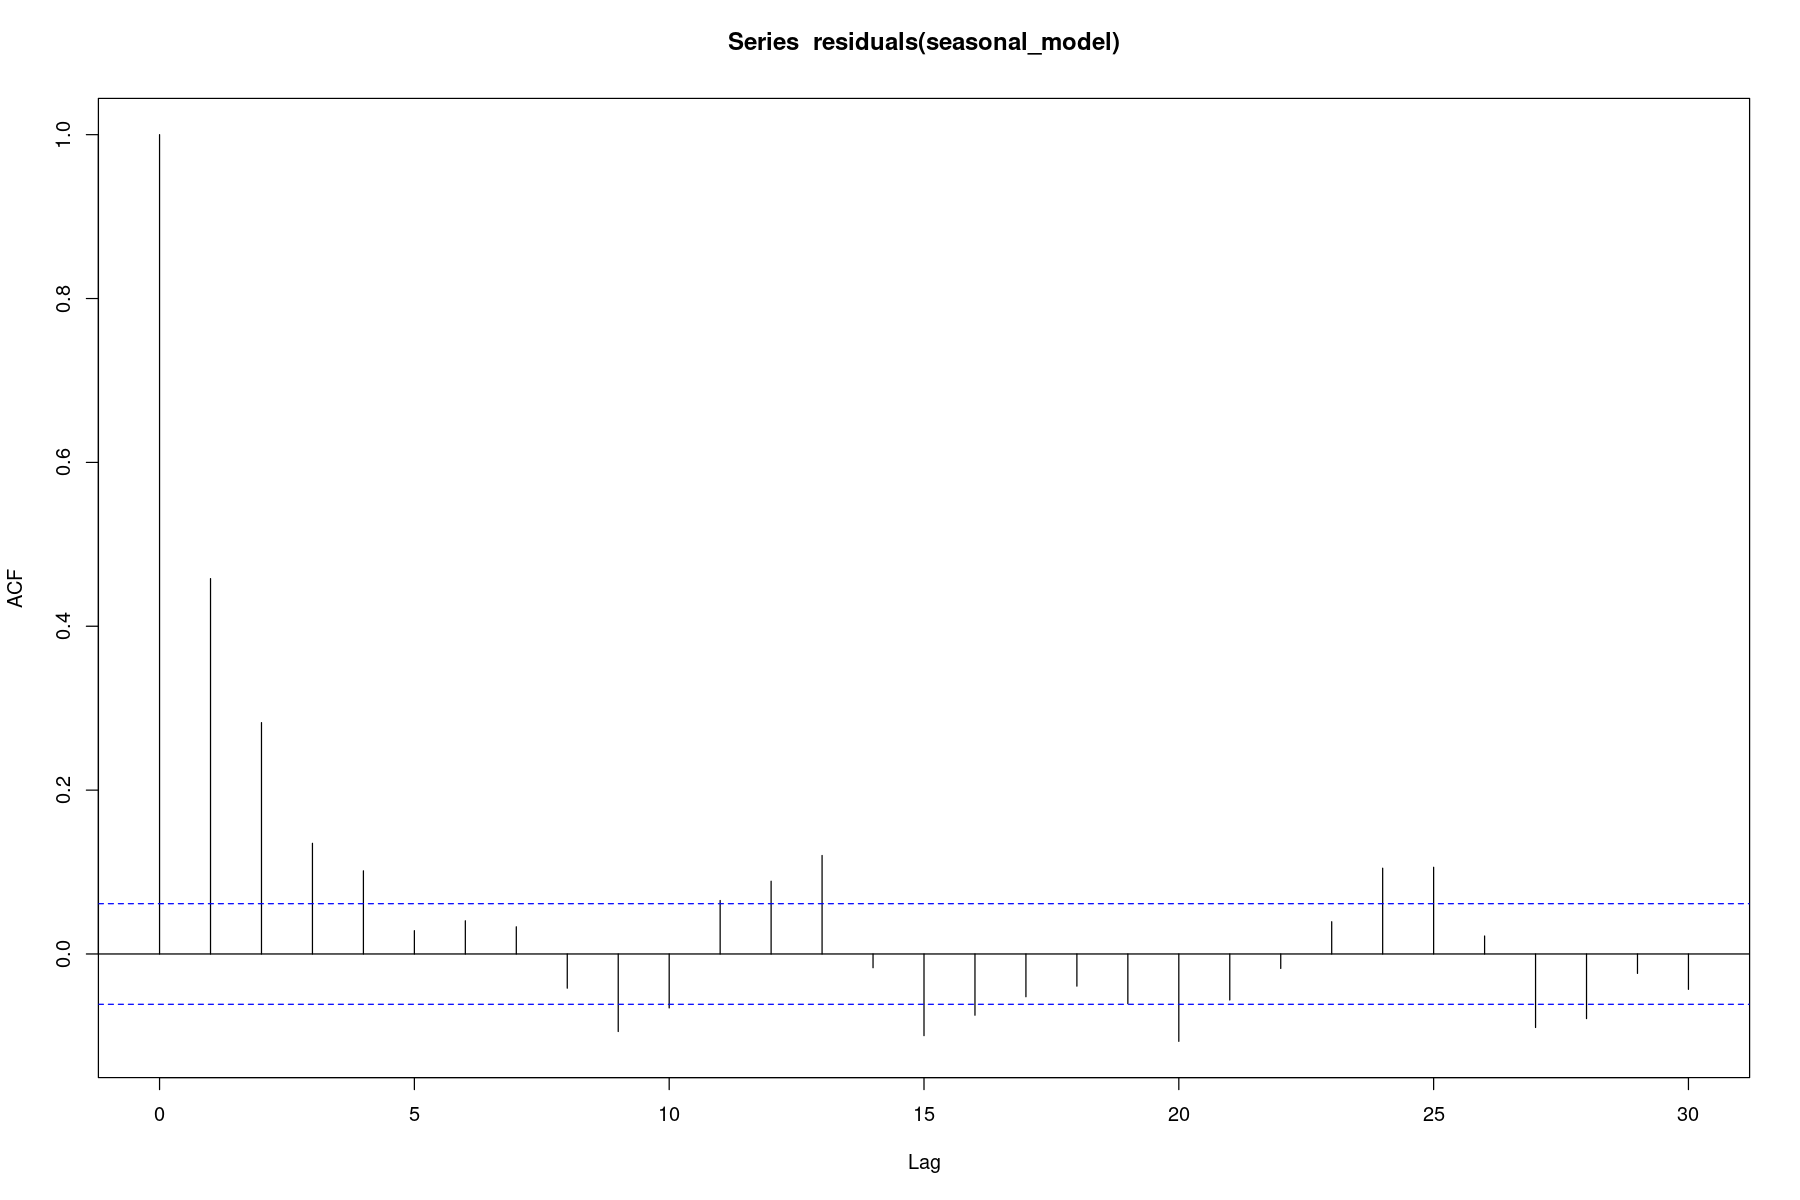

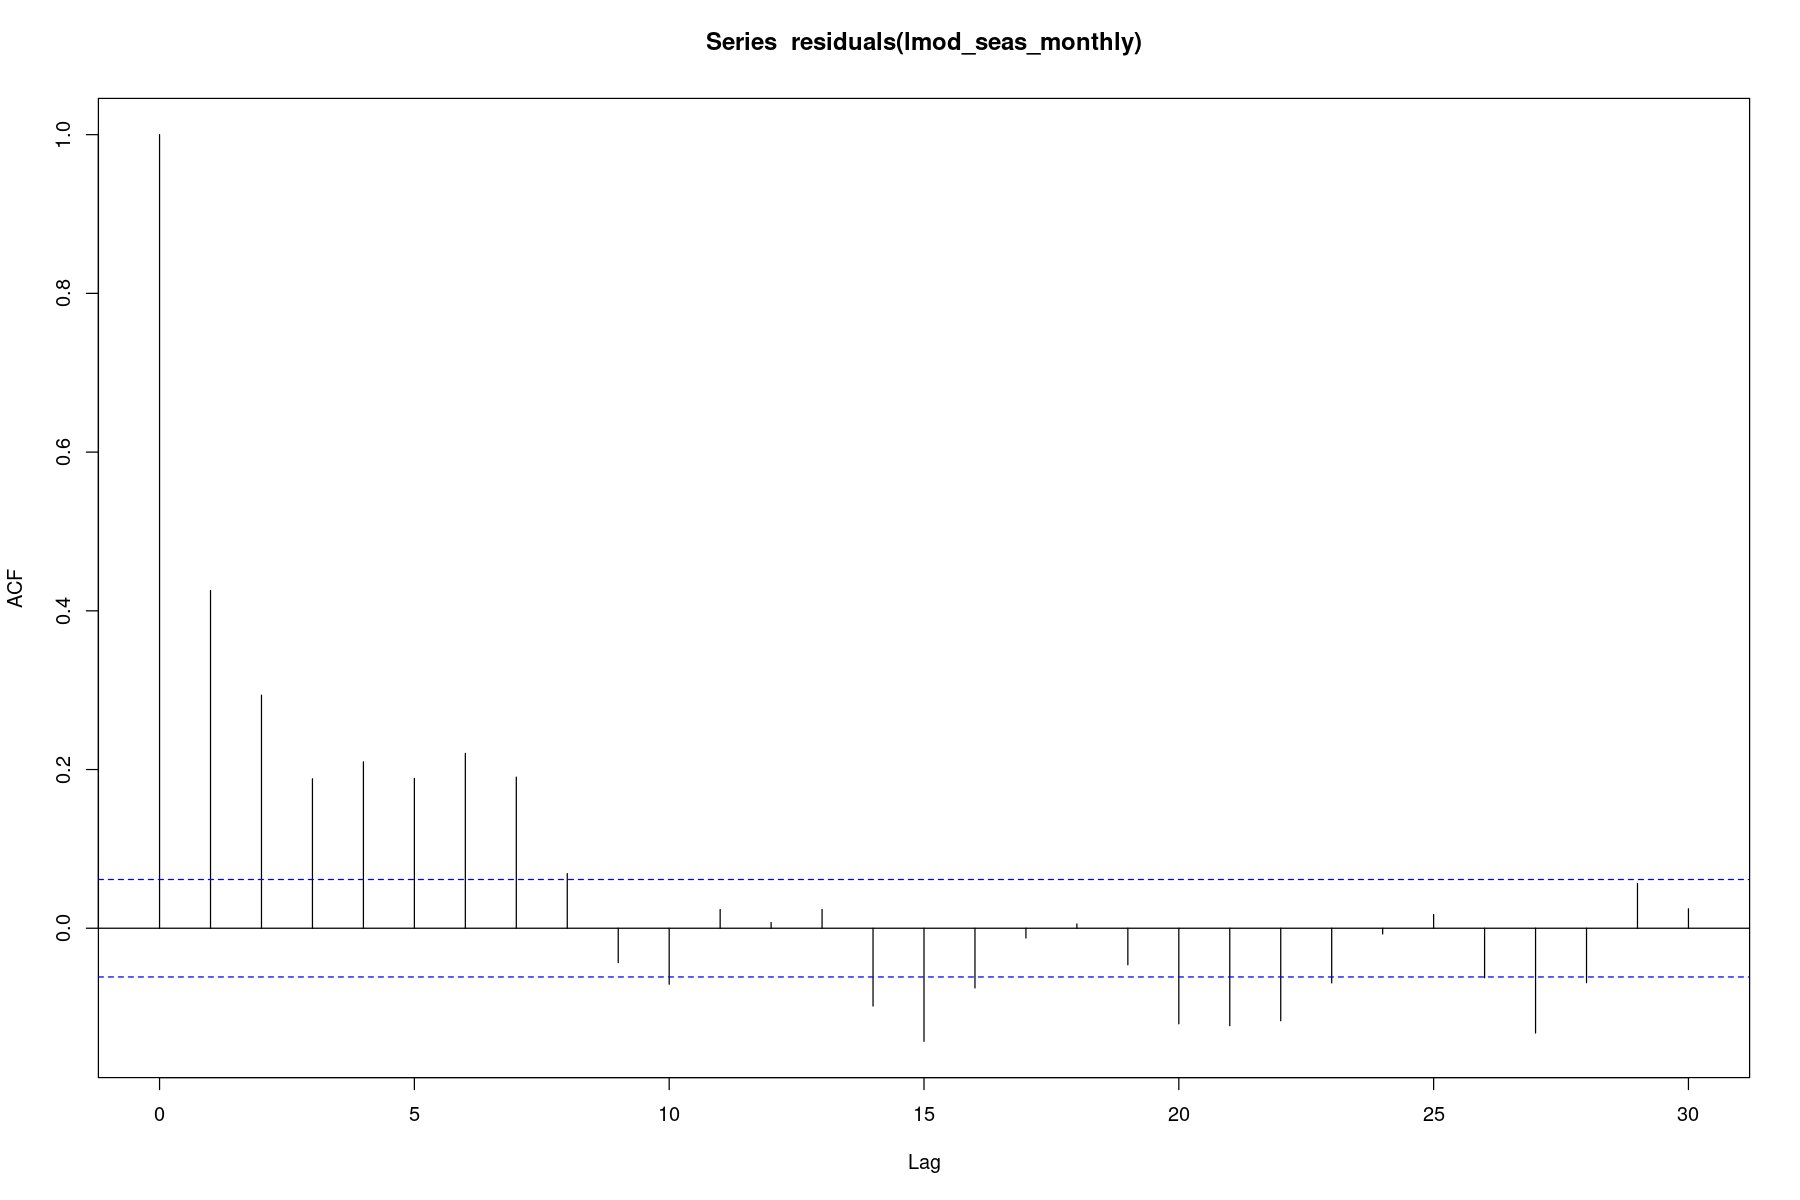

In [ ]:
par(bg = "white")
plot(acf(combined_dataset$log_variance, lag.max = 400))
plot(acf(residuals(seasonal_model), lag.max = 30))
plot(acf(residuals(lmod_seas_monthly), lag.max = 30))
